# Social Vulnerability Ireland - Calculate Vulnerability

## Environment

### R Libraries
The relvant R libraries are imported in to the kernal:

In [1]:
# Load R libraries
if(!require("pacman"))
    install.packages("pacman")

p_load("sf", "tidyverse")

print("Loaded Packages:")
p_loaded()

Loading required package: pacman



[1] "Loaded Packages:"


[1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "sf"        "pacman"

### Output directory

In [2]:
# create the output directory if it does not exist
output_dir <- file.path("../..","3_outputs","Ireland","2022")
if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
    print(paste0(output_dir, " created"))
}

### Set the GUID

In [3]:
GUID <- "SA_GUID__1"

## Load Data

### Import the data

In [4]:
# Load census data
census_indicator_data <- read.csv("../../2_pipeline/Ireland/1a_CensusData/2022/censusDataZ.csv")
colnames(census_indicator_data)[colnames(census_indicator_data) == "GUID"] = "SA_GUID__1"
head(census_indicator_data)

# Load Coperncius data: tree cover density (TCD) and imperviousness density (IMP)
tcd_indicator_data <- st_read("../../2_pipeline/Ireland/1b_Copernicus/2022/census_areas_TCD.geojson")
imd_indicator_data <- st_read("../../2_pipeline/Ireland/1b_Copernicus/2022/census_areas_IMD.geojson")

# Get the geospatial data from the TCS data (the IMD data also has same spatial data)
oa <- subset(tcd_indicator_data, select = c(GUID, 'geometry'))

# Load vulnerability mapping information from the config file
## This mapping information is used to help guide the amalgamation of the data.
## Weighting can be changed in this file, depending on the scenario.
## Scenario 1 (best case scenario): Weighting values 1 or -1:
##  where 1 means no change
##  or -1 means all the indicator values are multiplied by -1, resulting in an inverse indicator.
## Scenario 2: Weighting values 0.5 or -0.5:
##  For domains with just a single indicators or where there is a lack of information related to missing indicators. 
##  For these domains the weights are halved using a weight of 0.5, or -0.5 for an inverse indicator.
##  Therefore the influence of these indicators are reduced in half.
## Other scenarios are supported by using other decimal numbers if decided for a particular dataset.
indicator_mapping <- read.csv("config/vulnerabilityIndicatorMappings.csv", header=TRUE, sep=",", stringsAsFactors = FALSE, fileEncoding="UTF-8-BOM")

# Print up to 100 rows of vulnerabiltiy mapping config file
head(indicator_mapping,100)

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 4c07d11e-11d3-851d-e053-ca3ca8c0ca7f -0.1079508      -0.4448091              
2 4c07d11e-123a-851d-e053-ca3ca8c0ca7f -0.2315741       0.7875206              
3 4c07d11e-14b1-851d-e053-ca3ca8c0ca7f -0.3928420      -0.6320030              
4 bf640964-28f3-4ccf-a610-04685d80ea2e  0.7370521       0.3823155              
5 4c07d11d-f709-851d-e053-ca3ca8c0ca7f -0.1666197      -0.3376567              
6 4c07d11e-1237-851d-e053-ca3ca8c0ca7f  0.1772575       0.2407678              
  poor_health disability one_parent_households
1 -0.0867229  -0.4589362 -0.6992867           
2  0.1669895   0.5523710 -0.4125867           
3  1.2441066   0.2624819  0.4618750           
4  0.3432288  -0.1651002 -0.5449551           
5  0.1187018  -0.8724183 -0.3649398           
6  0.5828047   0.8390637 -0.4233032           
  three_or_more_children_households low_skilled_employment farmers   
1  0.7971503                         0.3821265              1.8818244
2  0.1677345                        -0.3005233              1.0930868
3 -0.3677598                        -0.4182116             -0.4741963
4 -0.6223328                        -0.7312063              0.1385892
5  0.2410678                        -0.3254920              1.6827210
6  0.4107411                         0.7385225              1.5548942
  unemployment ⋯ rented     journey_time not_volunteers primary_school_age
1 -0.83703083  ⋯ -0.9475582  0.6458280    0.2721853      0.53543614       
2 -0.26121797  ⋯ -0.9117719  0.3856925   -1.2744132     -0.09998755       
3  0.06414964  ⋯ -0.1088473  0.1347198   -0.4611731      0.29209620       
4 -0.18265319  ⋯ -0.7531121 -0.5219048   -0.7638791      0.28438525       
5 -0.28372469  ⋯ -1.0212046  0.3517089   -0.4219533      0.36431183       
6  0.45793149  ⋯ -0.7493154  0.9712513   -0.9921427      0.24013874       
  one_person_households no_central_heating private_water_supply year_built
1 -0.7988385            -0.7784105          2.8290832            0.1247138
2 -0.8885092             0.3283476          2.3937964            0.1865261
3 -0.4097515            -0.2296817         -0.4744110           -0.5141473
4 -0.1349893            -0.3651274          0.6291462            0.1706238
5 -0.1519057             0.6567264          2.2075847            0.4902435
6 -0.6550195            -0.2296817          0.3011058            0.7315812
  mobile_home unoccupied_dwellings
1  0.9507964  -0.2685905          
2 -0.1877926  -0.5759916          
3 -0.1877926  -0.5772738          
4  0.3058362  -0.5006639          
5  0.6692771  -0.3823238          
6  0.4676137  -0.3881432

Reading layer `census_areas_TCD' from data source 
  `/Cities/2_pipeline/Ireland/1b_Copernicus/2022/census_areas_TCD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 18919 features and 32 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 417471.5 ymin: 519663.7 xmax: 734481.1 ymax: 966896.3
Projected CRS: IRENET95 / Irish Transverse Mercator
Reading layer `census_areas_IMD' from data source 
  `/Cities/2_pipeline/Ireland/1b_Copernicus/2022/census_areas_IMD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 18919 features and 32 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 417471.5 ymin: 519663.7 xmax: 734481.1 ymax: 966896.3
Projected CRS: IRENET95 / Irish Transverse Mercator


domain                  indicator                         sensitivity
1  age                     early_childhood                   1          
2  age                     age_middle_to_oldest_old          1          
3  health                  poor_health                       1          
4  health                  disability                        1          
5  income                  one_parent_households             0          
6  income                  three_or_more_children_households 0          
7  income                  low_skilled_employment            0          
8  income                  farmers                           0          
9  income                  unemployment                      0          
10 info_access_use         no_higher_education               0          
11 info_access_use         speak_english                     0          
12 info_access_use         no_internet                       0          
13 local_knowledge         new_residents                     0          
14 local_knowledge         foreign_nationals                 0          
15 mobility                no_car                            0          
16 physical_access         journey_time                      0          
17 tenure                  rented                            0          
18 social_network          not_volunteers                    0          
19 social_network          primary_school_age                0          
20 social_network          one_person_households             0          
21 housing_characteristics no_central_heating                0          
22 housing_characteristics private_water_supply              0          
23 housing_characteristics year_built                        0          
24 housing_characteristics mobile_home                       0          
25 housing_characteristics unoccupied_dwellings              0          
26 physical_environment    impervious                        0          
27 physical_environment    tree_cover_density                0          
   prepare respond recover adaptive_capacity enhanced_exposure weight
1  0       0       0       0                 0                  1    
2  0       0       0       0                 0                  1    
3  0       0       0       0                 0                  1    
4  0       0       0       0                 0                  1    
5  1       1       1       1                 0                  1    
6  1       1       1       1                 0                  1    
7  1       1       1       1                 0                  1    
8  1       1       1       1                 0                  1    
9  1       1       1       1                 0                  1    
10 1       1       1       1                 0                  1    
11 1       1       1       1                 0                  1    
12 1       1       1       1                 0                  1    
13 1       1       0       1                 0                  1    
14 1       1       0       1                 0                  1    
15 0       1       1       1                 0                  1    
16 0       1       0       1                 0                  1    
17 1       0       0       1                 0                  1    
18 0       1       1       1                 0                  1    
19 0       1       1       1                 0                 -1    
20 0       1       1       1                 0                  1    
21 0       0       1       1                 0                  1    
22 0       0       1       1                 0                  1    
23 0       0       0       0                 1                  1    
24 0       0       0       0                 1                  1    
25 0       0       0       0                 1                  1    
26 0       0       0       0                 1                  1    
27 0       0       0       0                 1                  1

## Prepare Data

### Combine data into a single indicator dataset

In [5]:
# combine census data with copernicus TCD and IMD data (without geospatial data to advoid duplication)
indicator_data <- merge(tcd_indicator_data, st_drop_geometry(census_indicator_data), by.x = GUID, by.y = GUID, all.x = TRUE)
indicator_data <- merge(imd_indicator_data, st_drop_geometry(indicator_data), by=GUID)

# drop the geometry
indicator_data <- st_drop_geometry(indicator_data)

# change the small area id column data type (GUID) to character string
indicator_data[GUID] <- lapply(indicator_data[GUID], as.character)

# trim the columns
indicator_data <- subset(indicator_data, select=c(names(census_indicator_data), 'tree_cover_density', 'impervious'))

# Set missing data fields to zero (0)
# Note: In Italian census the NA or empty data fields are areas with no population (e.g. parks, schools, etc.)
indicator_data[is.na(indicator_data)] <- 0

# Print the first part of the indicators, which are now collated into one table
head(indicator_data)

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  3.3880435      -0.8683184              
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -1.2041476       1.0830212              
3 002b83e4-5cce-414a-8570-871a50ae0964  0.2940109      -0.6563918              
4 005eec3f-d746-480f-ae2c-bc6f1151548d -1.3337162       1.4547264              
5 00b00ae4-229d-455d-84f1-d6face4876b1  1.7131001      -1.2060316              
6 00df2b78-66c8-4009-89e0-0e14e15e4208  1.5084163      -0.8589597              
  poor_health disability  one_parent_households
1 -0.72494112 -0.92235833 -0.9537932           
2  0.27801178 -0.62611003 -0.5813707           
3  0.07647292  0.06773408  0.3083236           
4  0.49313225  0.45603900 -1.0918818           
5 -0.32805634 -0.03080027  3.2416831           
6 -1.03118100 -1.02730679 -0.4959203           
  three_or_more_children_households low_skilled_employment farmers   
1 -0.28864382                       -0.3191812             -0.5775435
2  0.24855343                       -0.7175350              0.2814244
3 -0.06192013                       -0.7370951             -0.1126775
4 -1.18351563                       -1.9157382             -0.5775435
5  1.26642096                        1.5271694             -0.5775435
6 -0.57201990                        0.4816479             -0.4599295
  unemployment ⋯ not_volunteers primary_school_age one_person_households
1 -0.61650259  ⋯  0.88627118     1.7138413         -1.4596182731        
2 -0.23523246  ⋯ -0.81754631    -0.5610249         -0.0009715101        
3  0.22240140  ⋯  0.52365099     0.3585112         -0.2053615213        
4 -0.07660151  ⋯ -0.27505307    -1.3574765         -0.6525911498        
5  0.75768133  ⋯  1.59439615     2.9123134         -1.1159542610        
6 -0.97841257  ⋯ -0.02986993     0.6262758         -0.9415702944        
  no_central_heating private_water_supply year_built mobile_home
1 -0.7784105         -0.5390374           -0.8371139 -0.1877926 
2 -0.7784105          1.3835981           -0.4334056 -0.1877926 
3 -0.1120970         -0.5390374           -0.7250643 -0.1877926 
4 -0.1318884         -0.3106055           -0.7827532 -0.1877926 
5 -0.7784105         -0.5390374           -0.7424513 -0.1877926 
6 -0.7784105         -0.5390374           -0.6196710 -0.1877926 
  unoccupied_dwellings tree_cover_density impervious
1 -0.2345322           0.7388976          -0.3062498
2 -0.3975997           0.1744364          -0.4046076
3 -0.5907831           0.3864675           0.2528562
4 -0.3274716           0.7008530           0.5785962
5 -0.6509695           0.4060470           0.5467661
6 -0.4166064           0.7989094          -0.4272128

### Weight the indicator datas 

In [6]:
# Get the indicator weighting, previously loaded from the config file
indicator_weighting <- indicator_mapping %>% select('indicator', 'weight')
indicator_weighting <- indicator_weighting %>% spread(key = 'indicator', value = 'weight')

# Get the column names and weights
names <- names(indicator_weighting)
weights <- indicator_weighting[, names]

# Copy and rename the dataset
indicator_data_weighted <- indicator_data
head(indicator_data_weighted) 

# Multiply the indicators by the config file weighting
indicator_data_weighted[, names] <- sweep(indicator_data_weighted[, names], 2, unlist(weights[, names]), "*")
head(indicator_data_weighted)

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  3.3880435      -0.8683184              
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -1.2041476       1.0830212              
3 002b83e4-5cce-414a-8570-871a50ae0964  0.2940109      -0.6563918              
4 005eec3f-d746-480f-ae2c-bc6f1151548d -1.3337162       1.4547264              
5 00b00ae4-229d-455d-84f1-d6face4876b1  1.7131001      -1.2060316              
6 00df2b78-66c8-4009-89e0-0e14e15e4208  1.5084163      -0.8589597              
  poor_health disability  one_parent_households
1 -0.72494112 -0.92235833 -0.9537932           
2  0.27801178 -0.62611003 -0.5813707           
3  0.07647292  0.06773408  0.3083236           
4  0.49313225  0.45603900 -1.0918818           
5 -0.32805634 -0.03080027  3.2416831           
6 -1.03118100 -1.02730679 -0.4959203           
  three_or_more_children_households low_skilled_employment farmers   
1 -0.28864382                       -0.3191812             -0.5775435
2  0.24855343                       -0.7175350              0.2814244
3 -0.06192013                       -0.7370951             -0.1126775
4 -1.18351563                       -1.9157382             -0.5775435
5  1.26642096                        1.5271694             -0.5775435
6 -0.57201990                        0.4816479             -0.4599295
  unemployment ⋯ not_volunteers primary_school_age one_person_households
1 -0.61650259  ⋯  0.88627118     1.7138413         -1.4596182731        
2 -0.23523246  ⋯ -0.81754631    -0.5610249         -0.0009715101        
3  0.22240140  ⋯  0.52365099     0.3585112         -0.2053615213        
4 -0.07660151  ⋯ -0.27505307    -1.3574765         -0.6525911498        
5  0.75768133  ⋯  1.59439615     2.9123134         -1.1159542610        
6 -0.97841257  ⋯ -0.02986993     0.6262758         -0.9415702944        
  no_central_heating private_water_supply year_built mobile_home
1 -0.7784105         -0.5390374           -0.8371139 -0.1877926 
2 -0.7784105          1.3835981           -0.4334056 -0.1877926 
3 -0.1120970         -0.5390374           -0.7250643 -0.1877926 
4 -0.1318884         -0.3106055           -0.7827532 -0.1877926 
5 -0.7784105         -0.5390374           -0.7424513 -0.1877926 
6 -0.7784105         -0.5390374           -0.6196710 -0.1877926 
  unoccupied_dwellings tree_cover_density impervious
1 -0.2345322           0.7388976          -0.3062498
2 -0.3975997           0.1744364          -0.4046076
3 -0.5907831           0.3864675           0.2528562
4 -0.3274716           0.7008530           0.5785962
5 -0.6509695           0.4060470           0.5467661
6 -0.4166064           0.7989094          -0.4272128

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  3.3880435      -0.8683184              
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -1.2041476       1.0830212              
3 002b83e4-5cce-414a-8570-871a50ae0964  0.2940109      -0.6563918              
4 005eec3f-d746-480f-ae2c-bc6f1151548d -1.3337162       1.4547264              
5 00b00ae4-229d-455d-84f1-d6face4876b1  1.7131001      -1.2060316              
6 00df2b78-66c8-4009-89e0-0e14e15e4208  1.5084163      -0.8589597              
  poor_health disability  one_parent_households
1 -0.72494112 -0.92235833 -0.9537932           
2  0.27801178 -0.62611003 -0.5813707           
3  0.07647292  0.06773408  0.3083236           
4  0.49313225  0.45603900 -1.0918818           
5 -0.32805634 -0.03080027  3.2416831           
6 -1.03118100 -1.02730679 -0.4959203           
  three_or_more_children_households low_skilled_employment farmers   
1 -0.28864382                       -0.3191812             -0.5775435
2  0.24855343                       -0.7175350              0.2814244
3 -0.06192013                       -0.7370951             -0.1126775
4 -1.18351563                       -1.9157382             -0.5775435
5  1.26642096                        1.5271694             -0.5775435
6 -0.57201990                        0.4816479             -0.4599295
  unemployment ⋯ not_volunteers primary_school_age one_person_households
1 -0.61650259  ⋯  0.88627118    -1.7138413         -1.4596182731        
2 -0.23523246  ⋯ -0.81754631     0.5610249         -0.0009715101        
3  0.22240140  ⋯  0.52365099    -0.3585112         -0.2053615213        
4 -0.07660151  ⋯ -0.27505307     1.3574765         -0.6525911498        
5  0.75768133  ⋯  1.59439615    -2.9123134         -1.1159542610        
6 -0.97841257  ⋯ -0.02986993    -0.6262758         -0.9415702944        
  no_central_heating private_water_supply year_built mobile_home
1 -0.7784105         -0.5390374           -0.8371139 -0.1877926 
2 -0.7784105          1.3835981           -0.4334056 -0.1877926 
3 -0.1120970         -0.5390374           -0.7250643 -0.1877926 
4 -0.1318884         -0.3106055           -0.7827532 -0.1877926 
5 -0.7784105         -0.5390374           -0.7424513 -0.1877926 
6 -0.7784105         -0.5390374           -0.6196710 -0.1877926 
  unoccupied_dwellings tree_cover_density impervious
1 -0.2345322           0.7388976          -0.3062498
2 -0.3975997           0.1744364          -0.4046076
3 -0.5907831           0.3864675           0.2528562
4 -0.3274716           0.7008530           0.5785962
5 -0.6509695           0.4060470           0.5467661
6 -0.4166064           0.7989094          -0.4272128

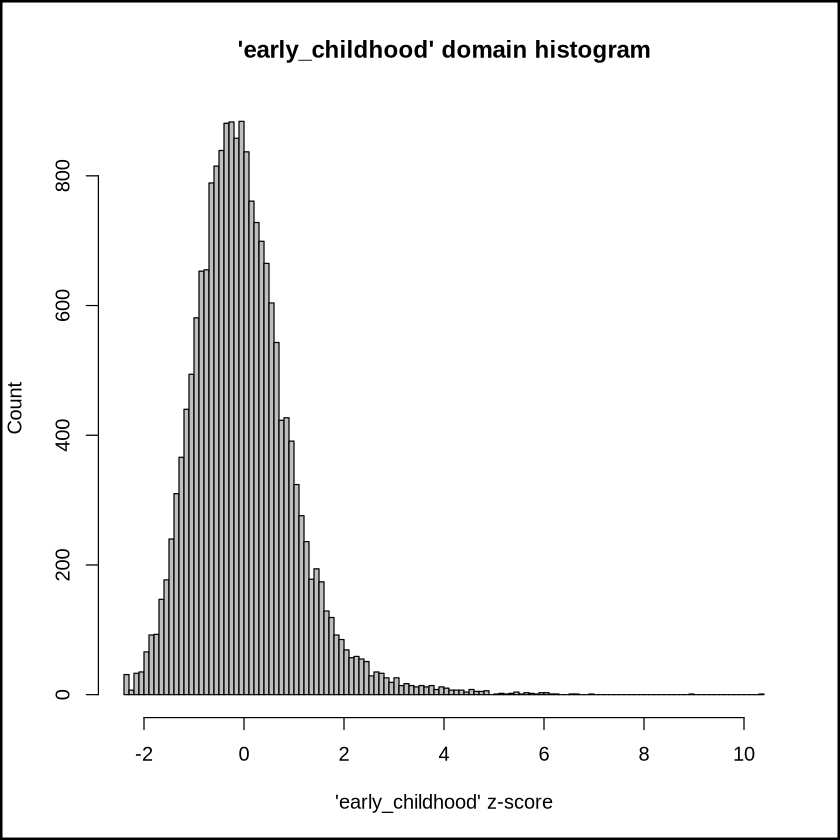

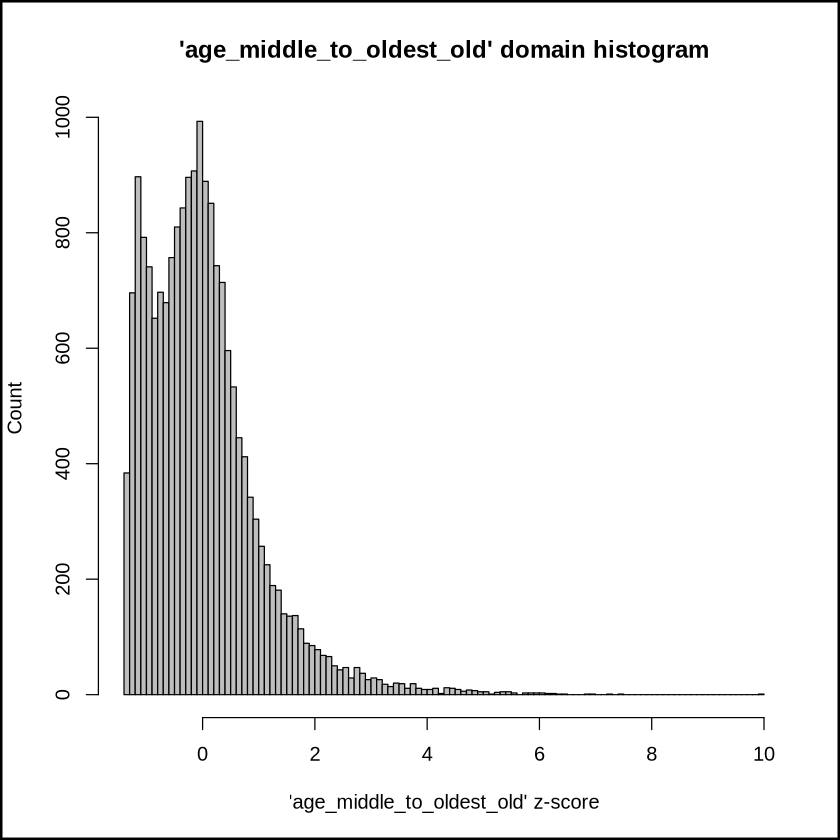

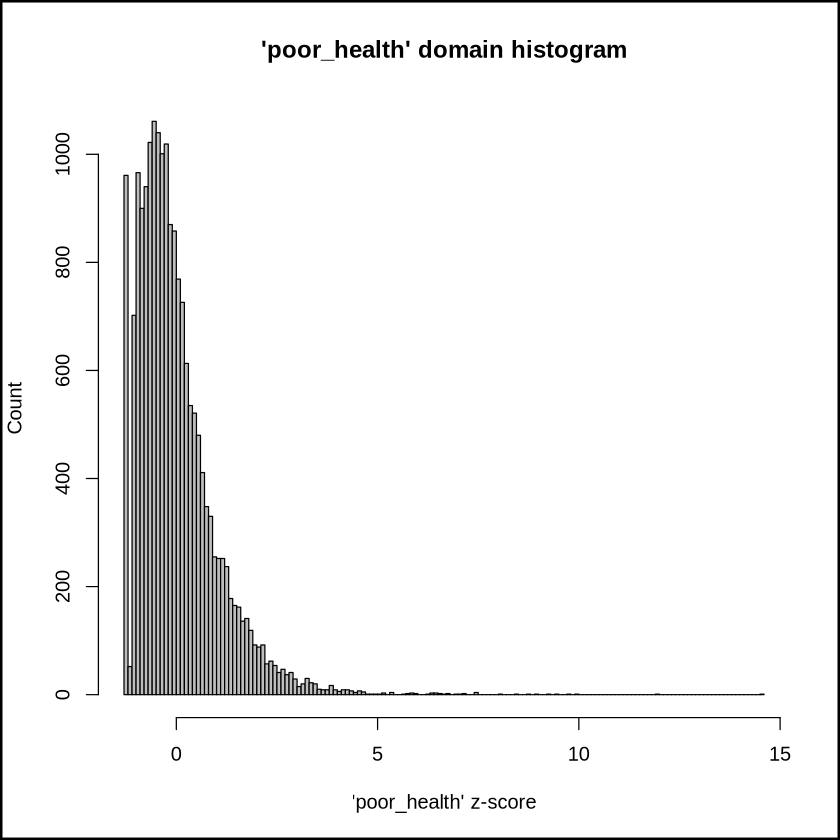

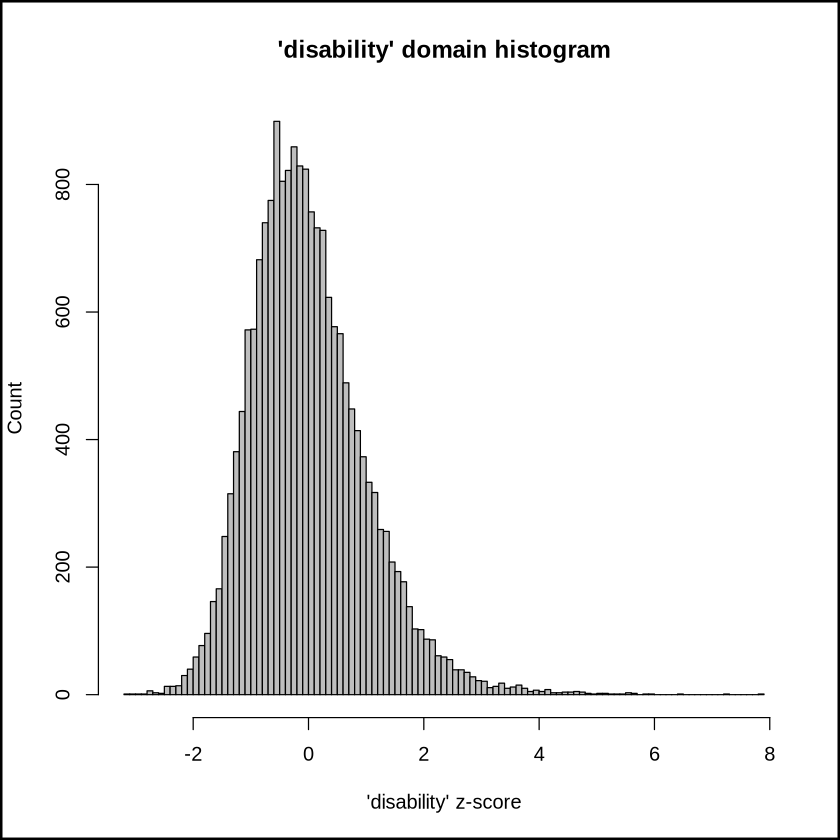

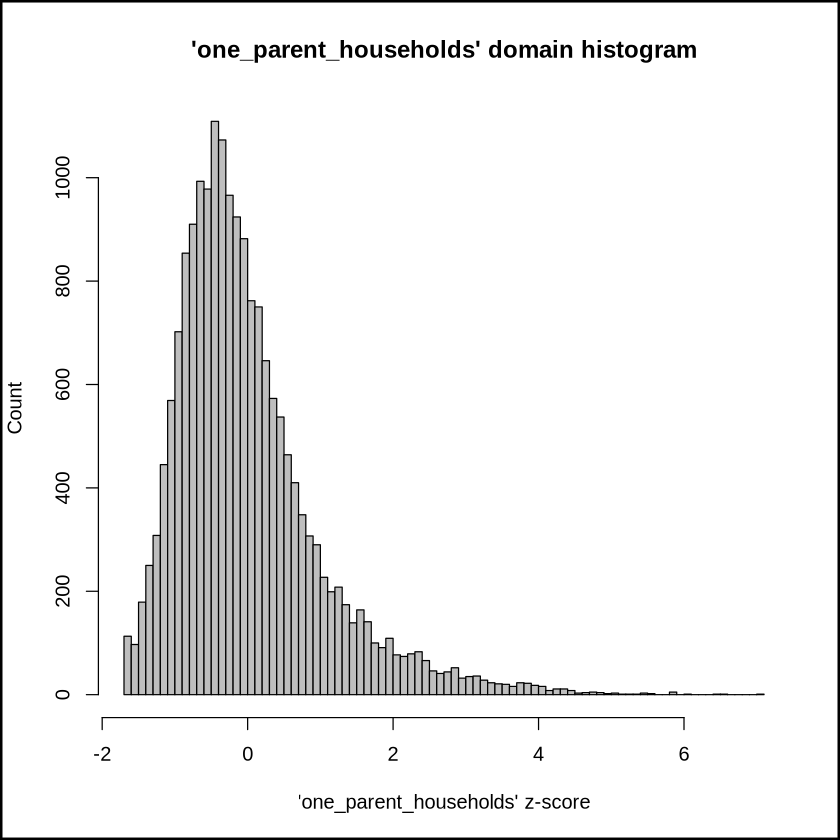

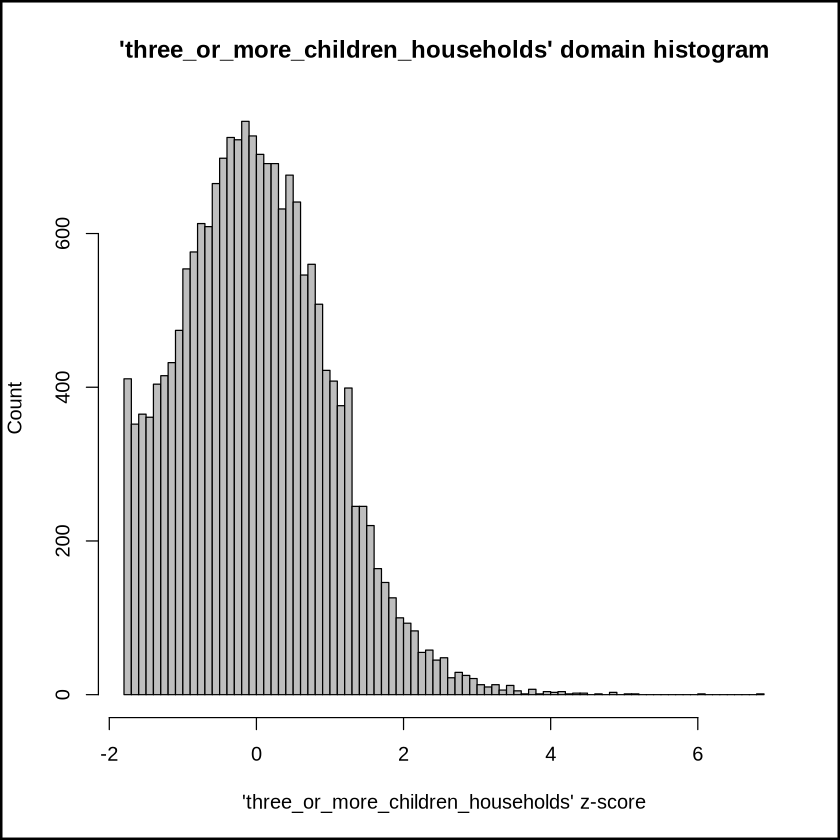

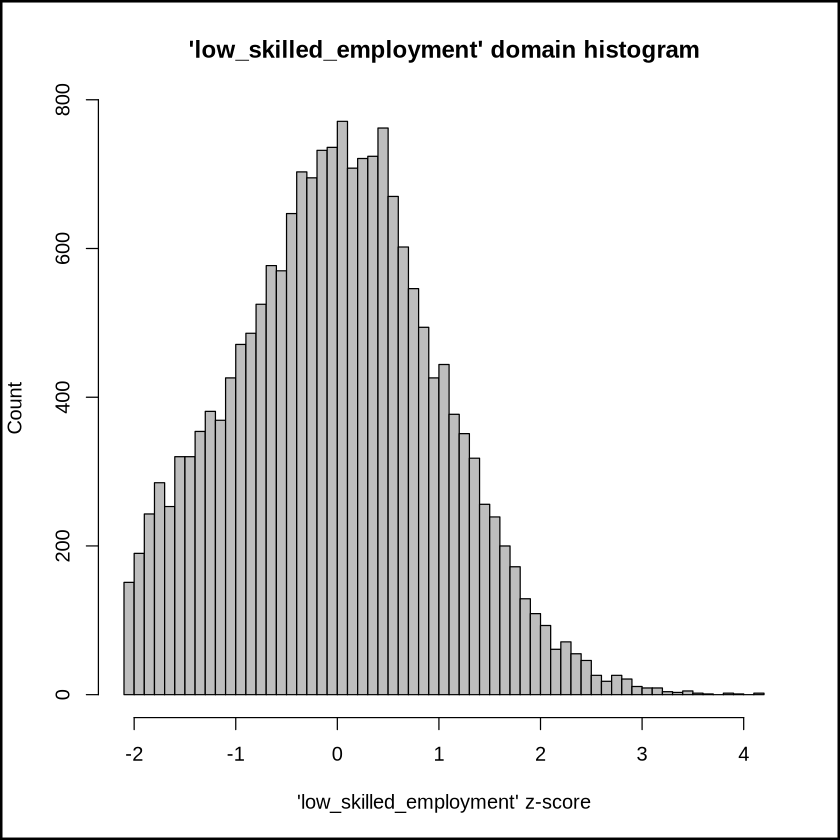

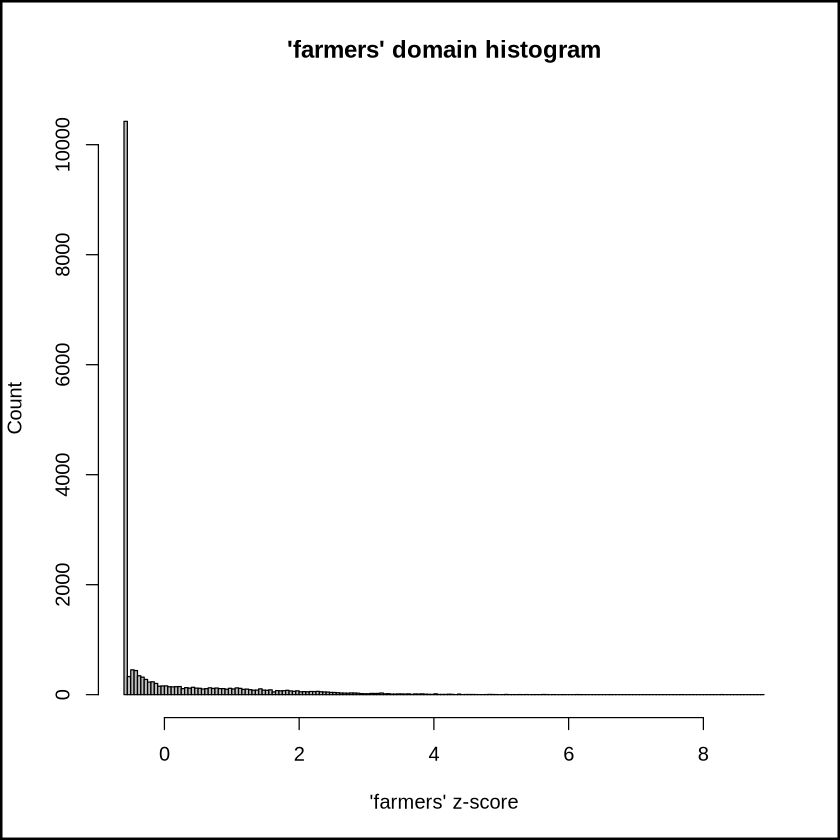

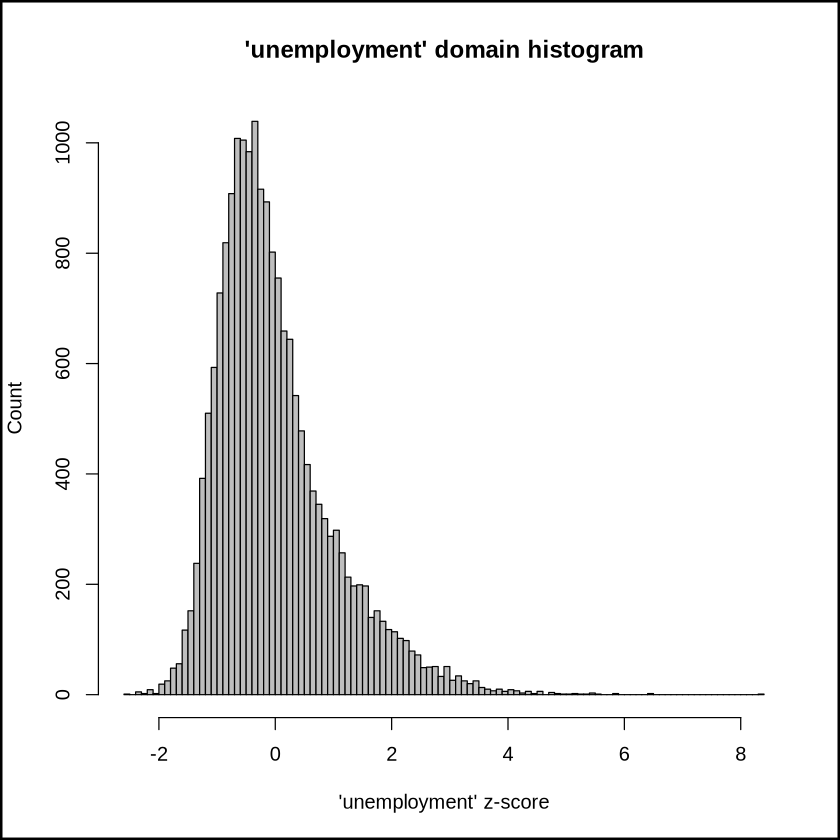

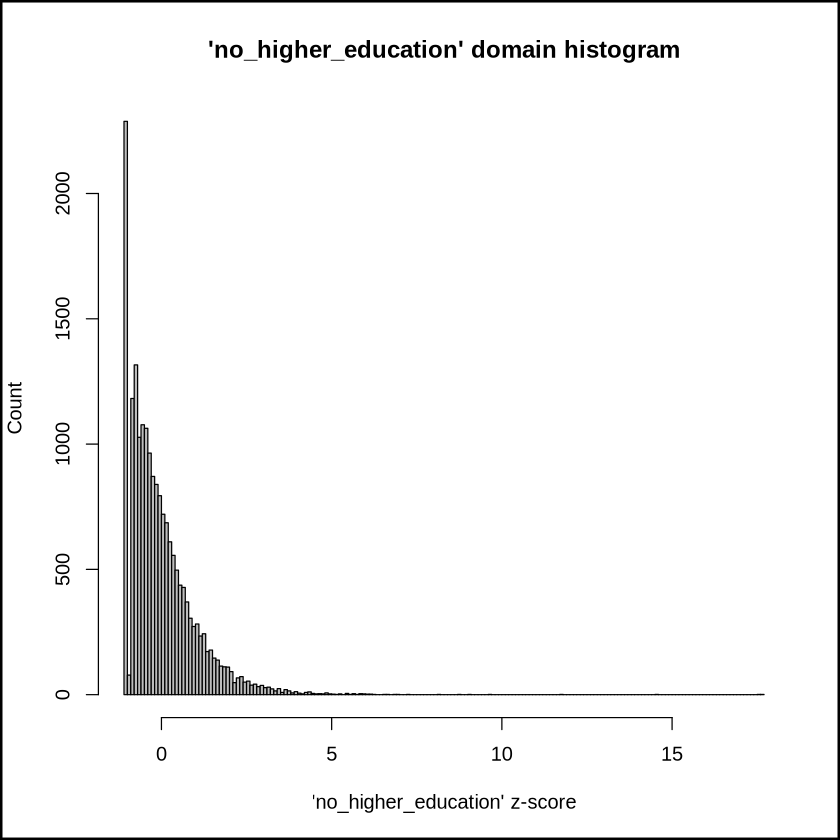

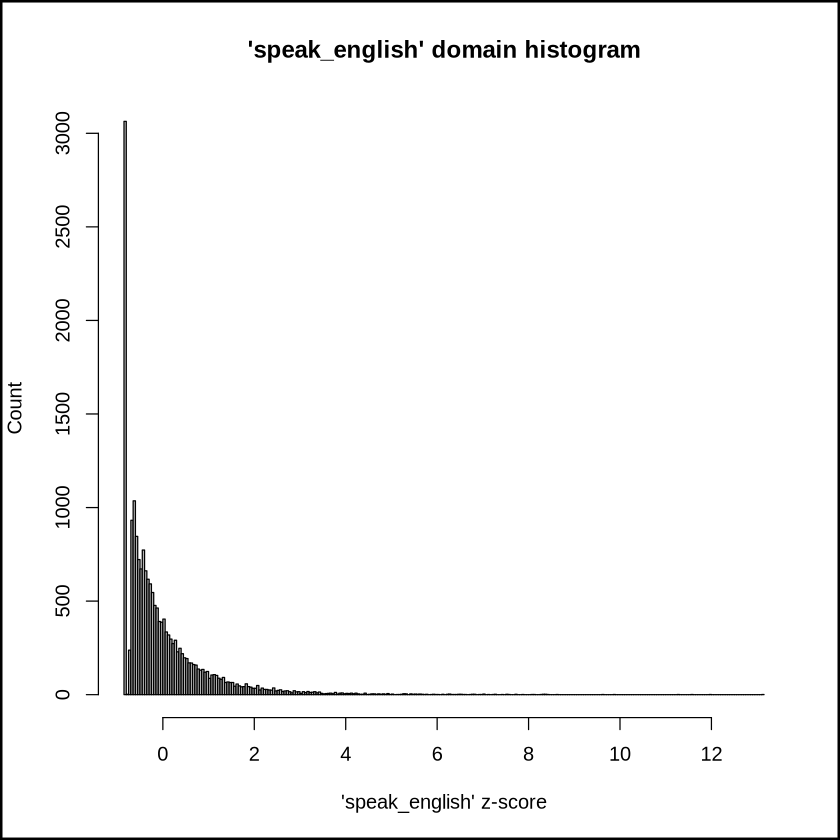

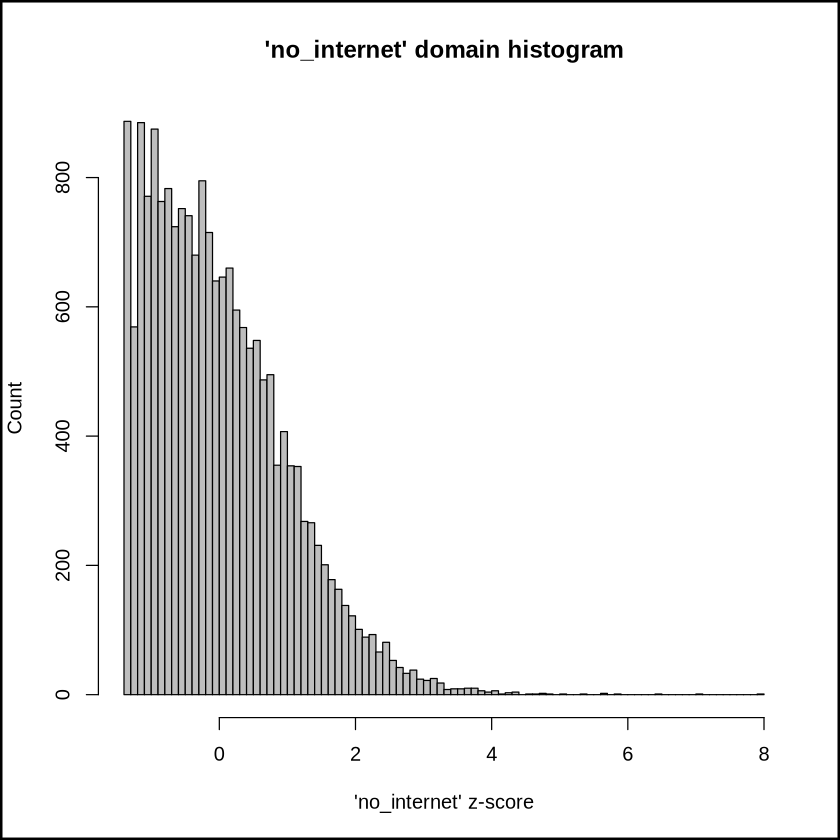

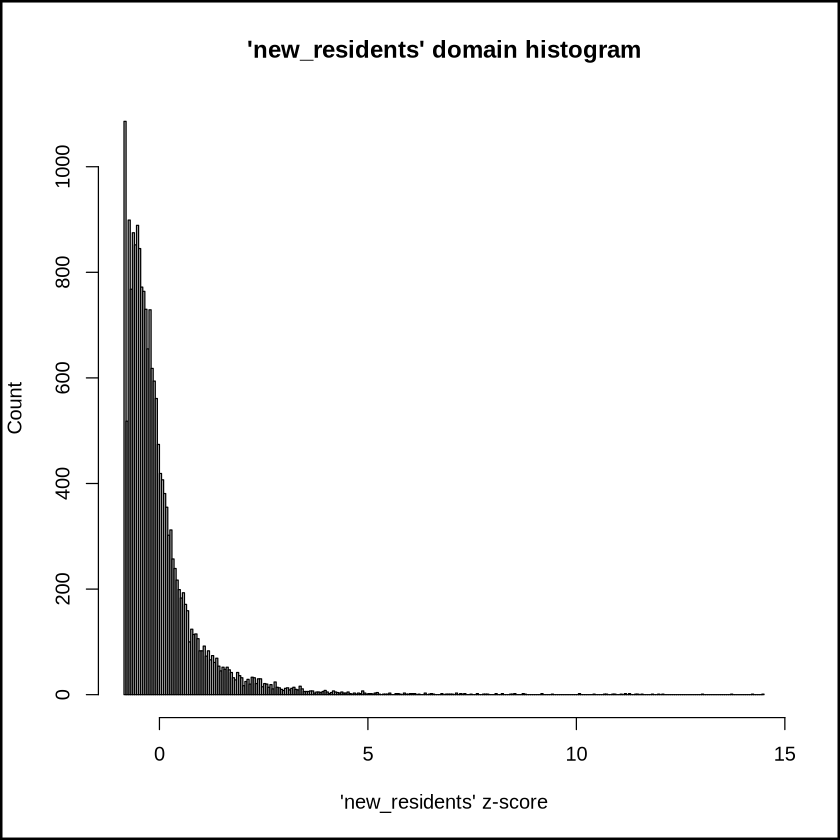

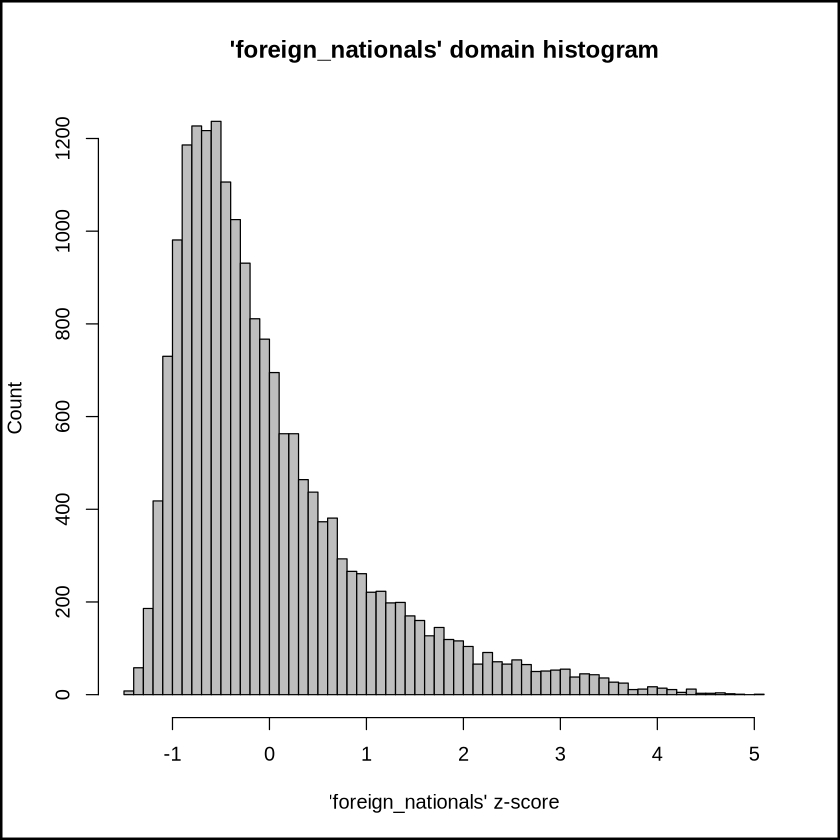

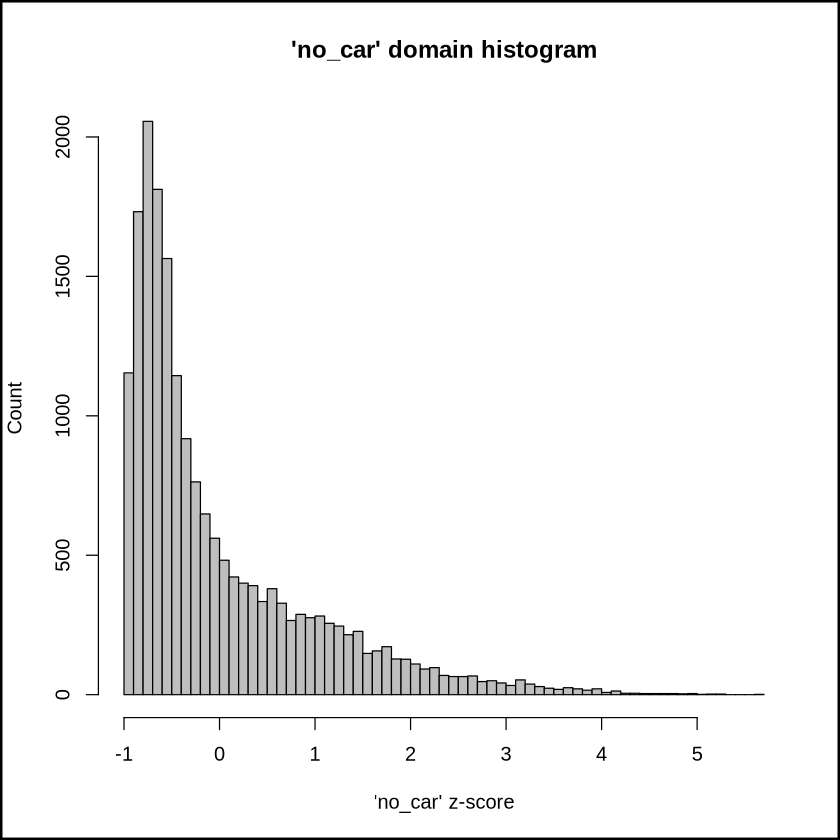

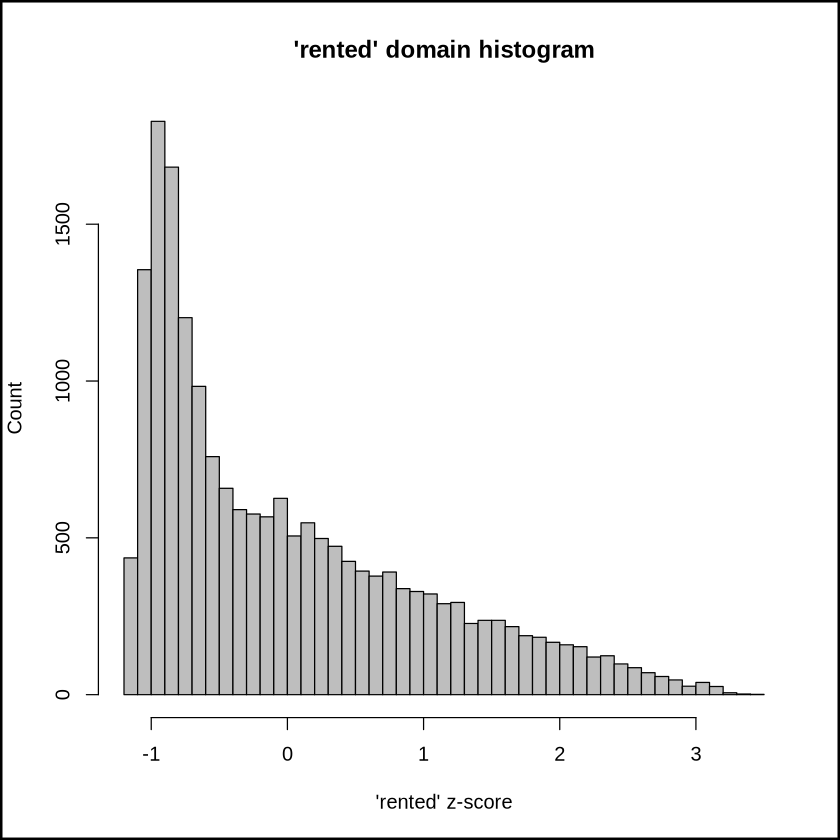

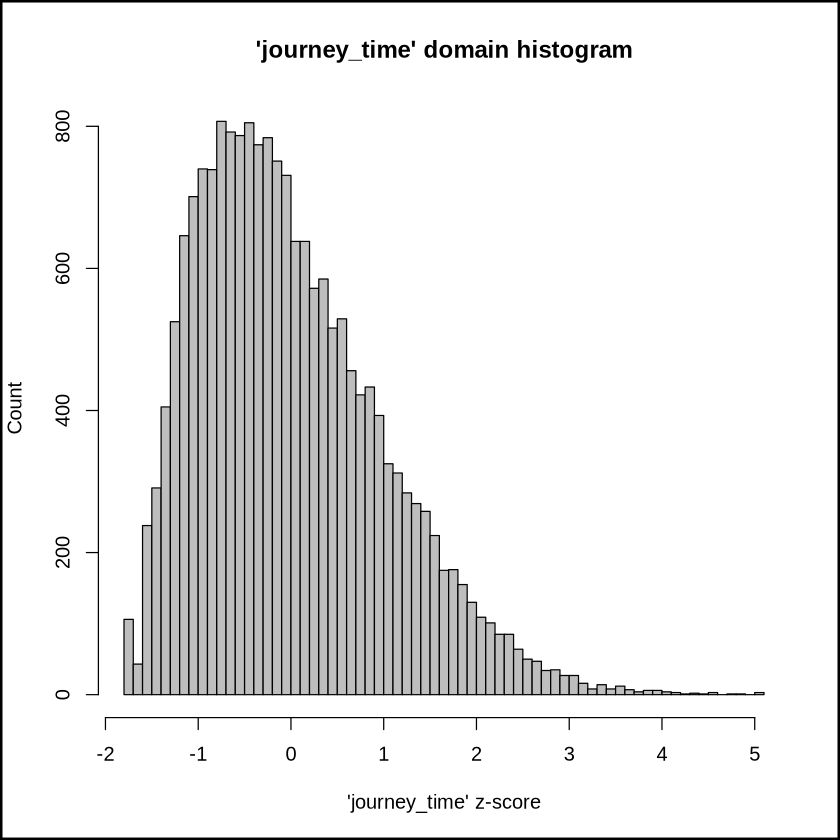

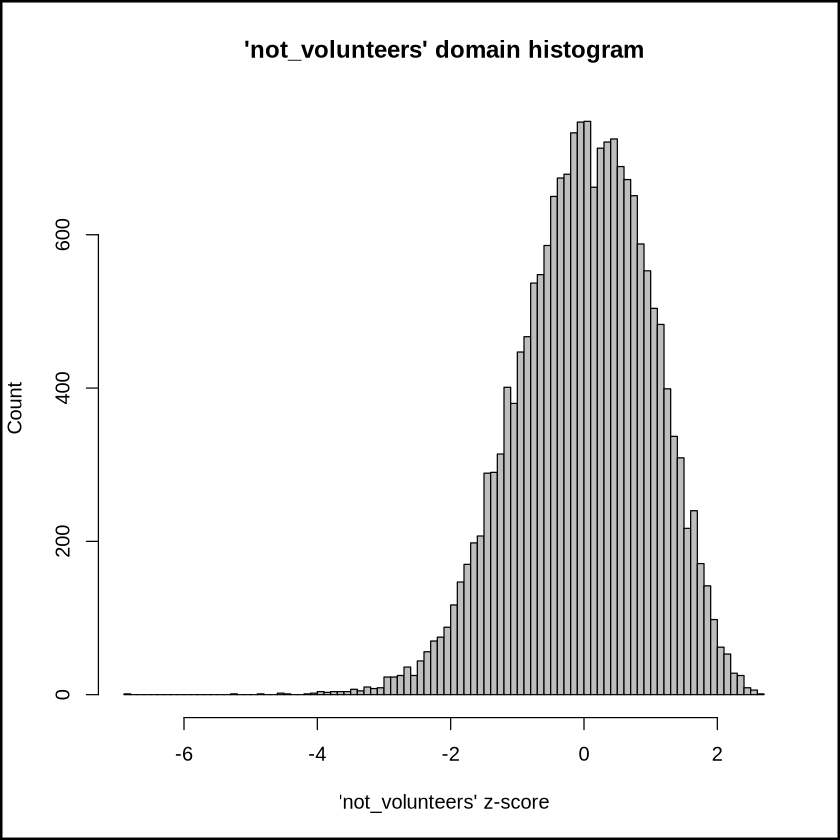

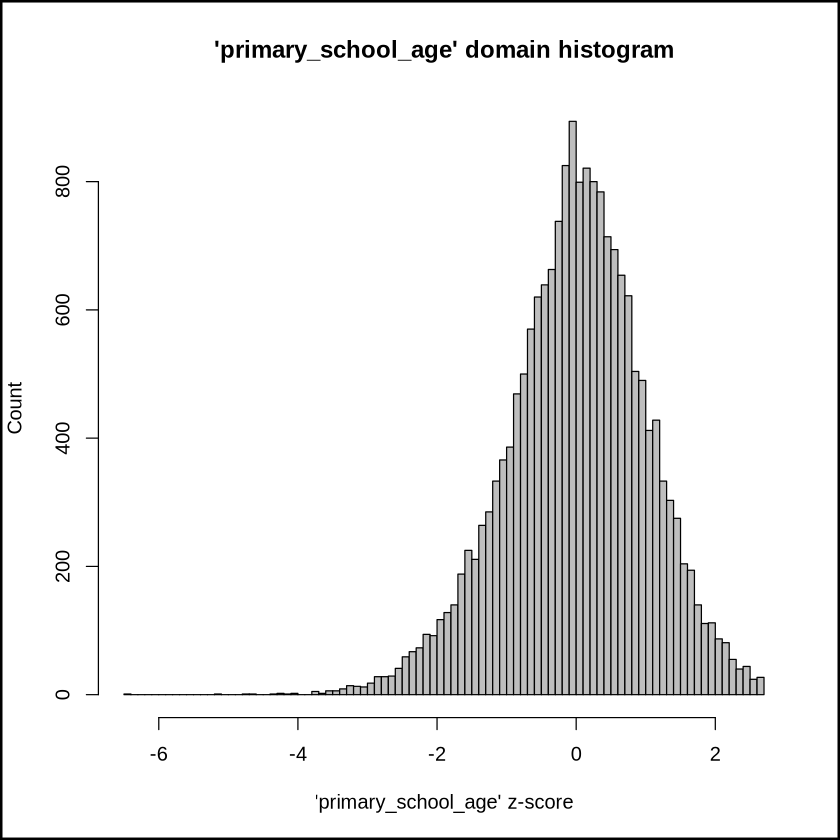

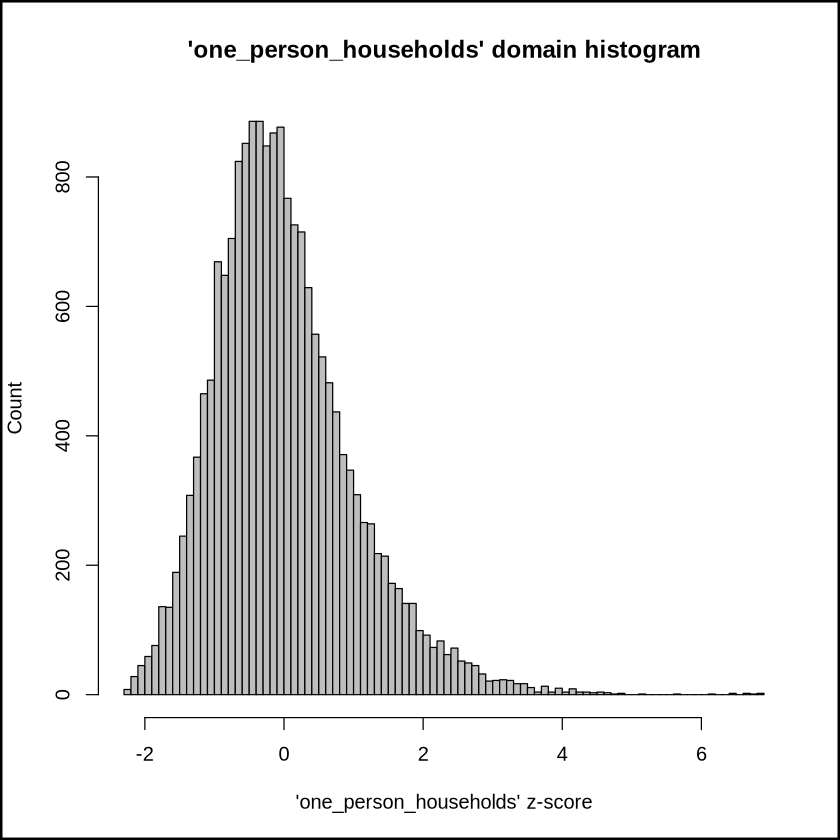

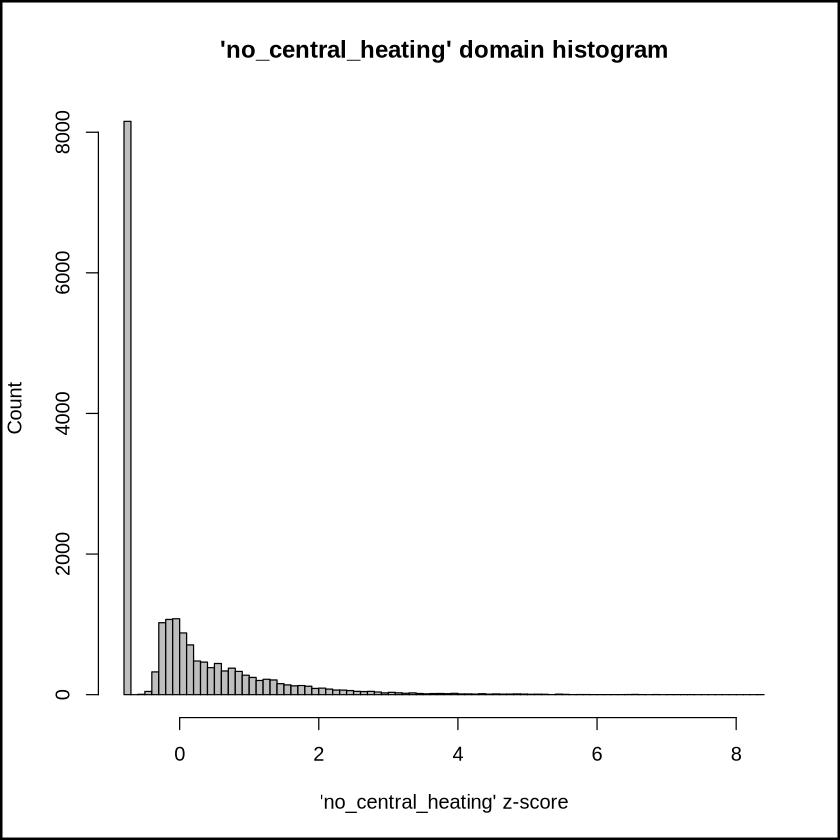

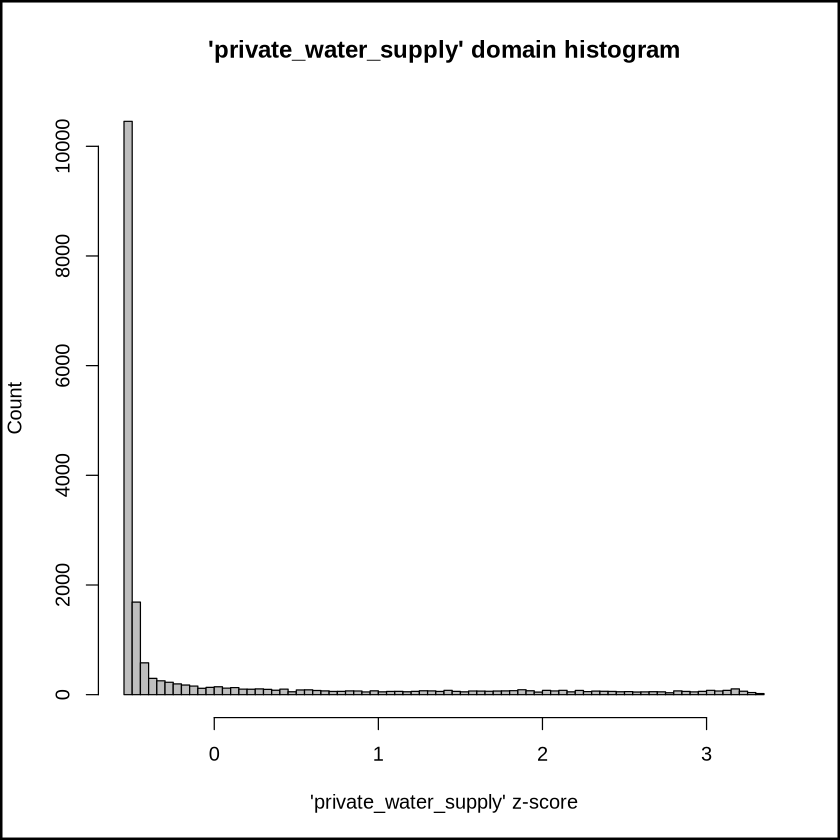

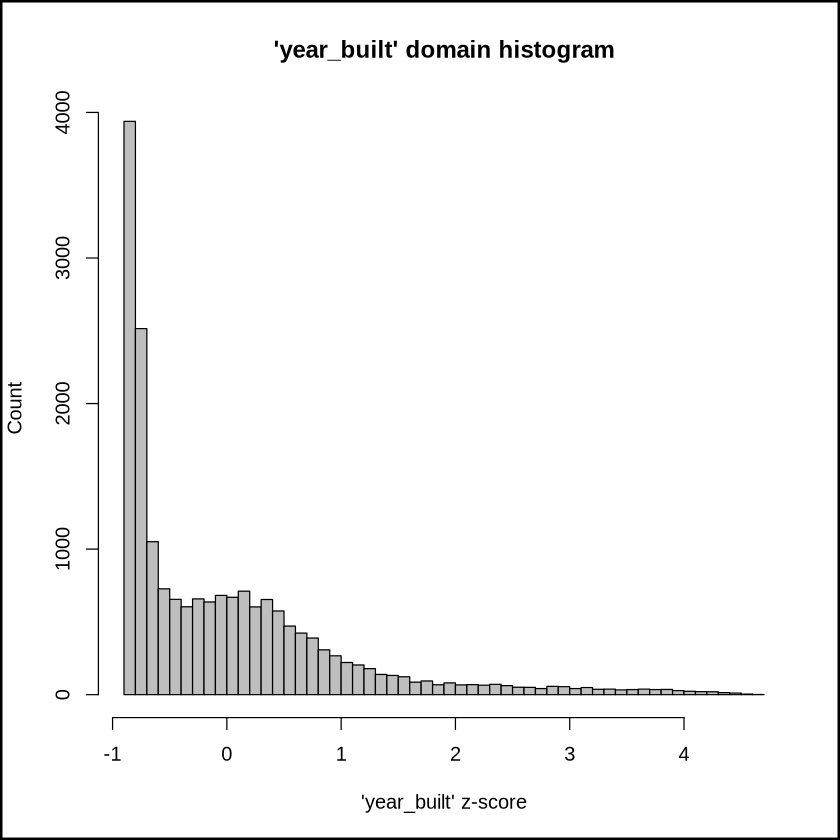

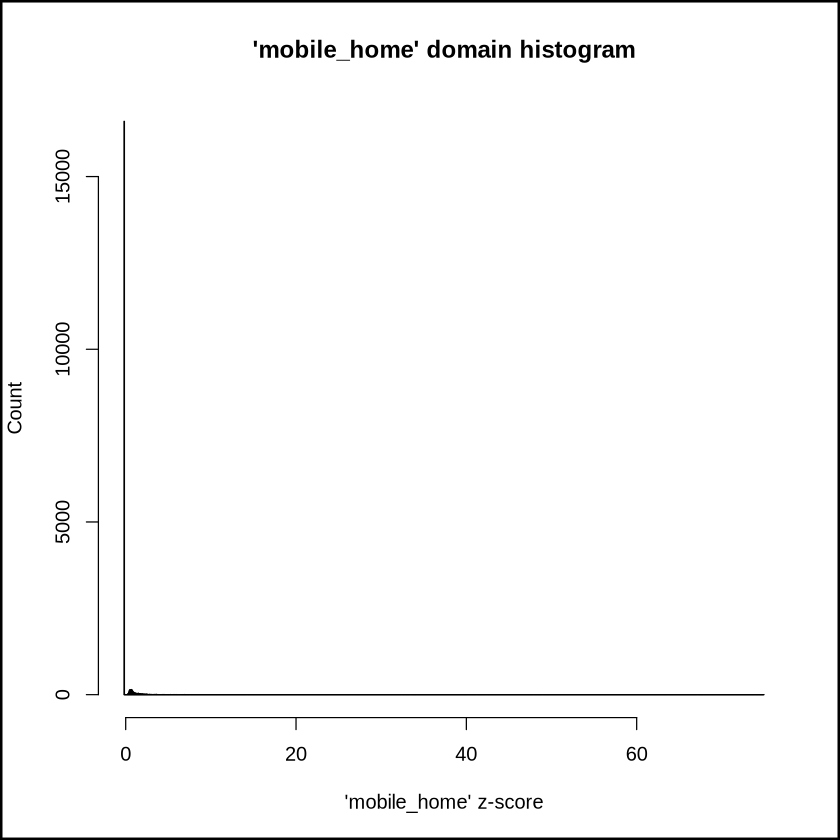

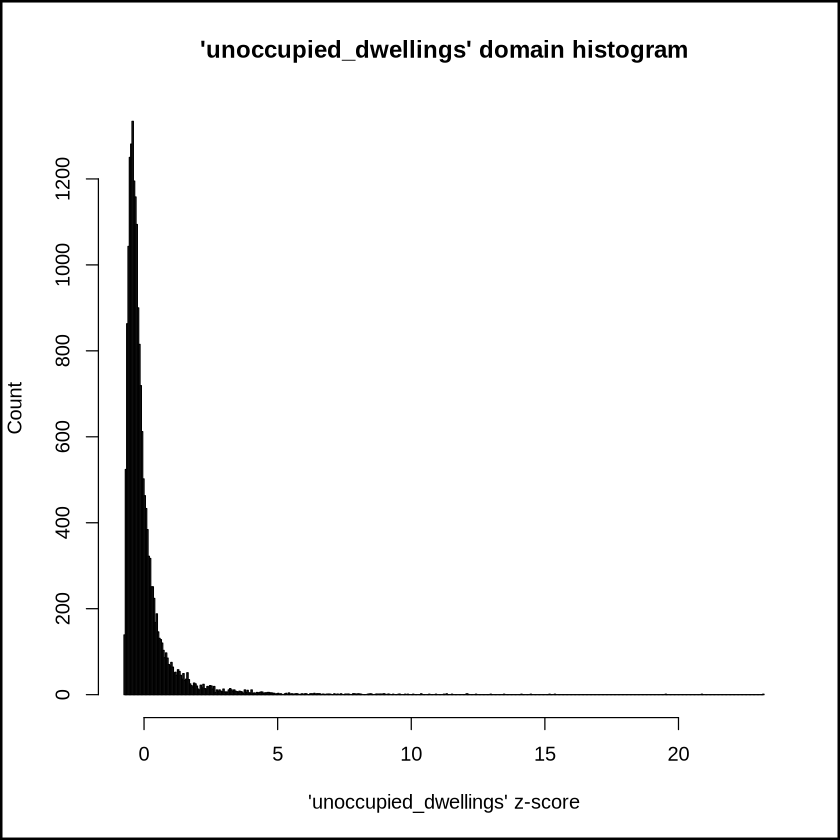

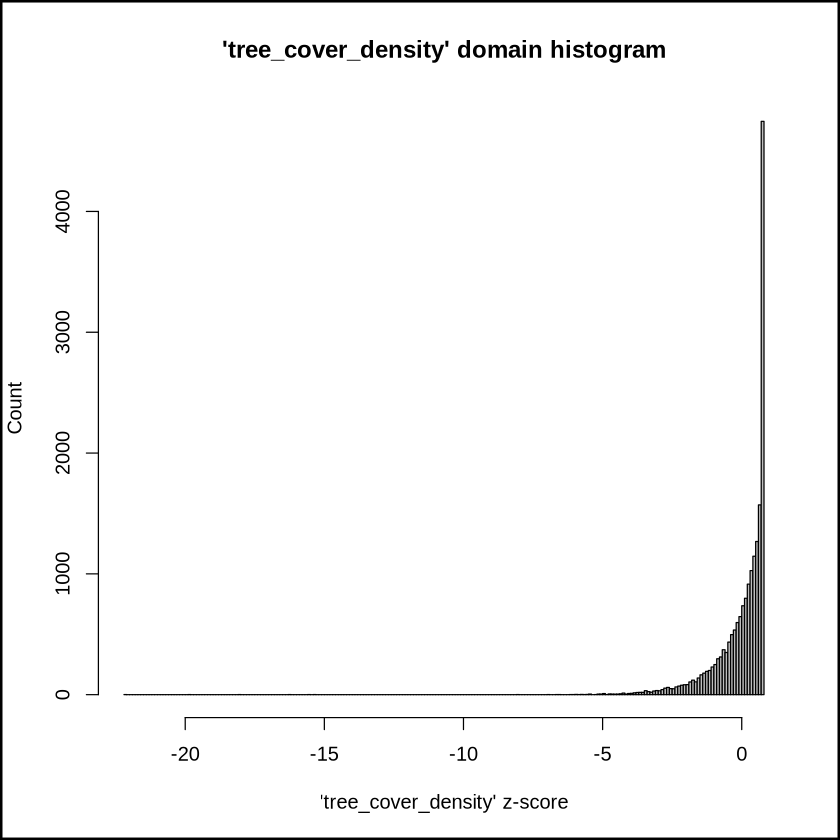

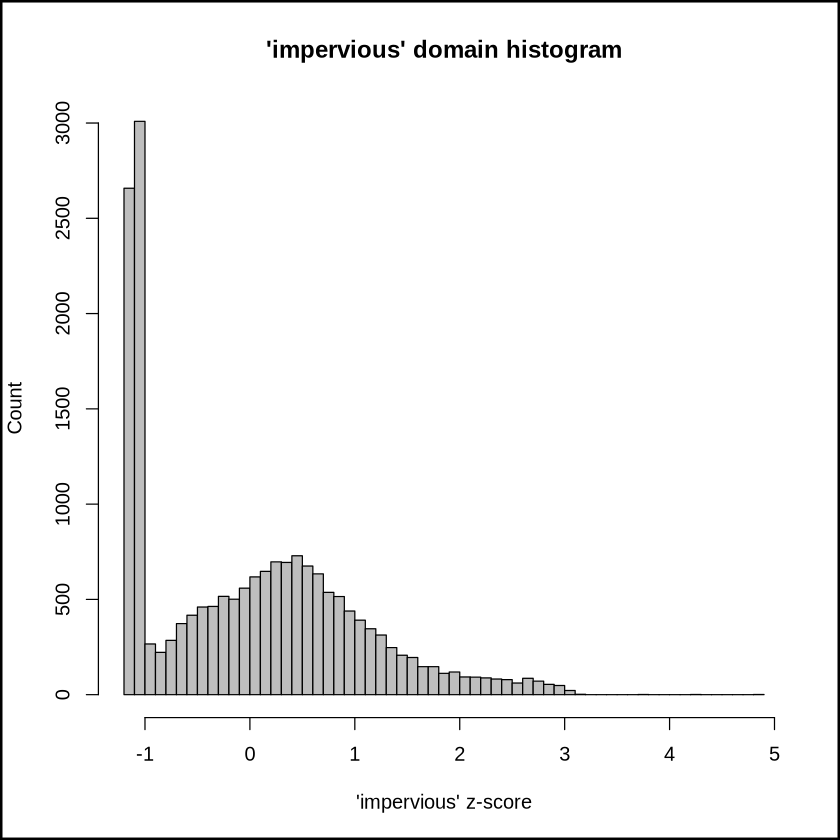

In [7]:
# Histogram visualisation of weighted indicators
indicator_columns <- colnames(indicator_data_weighted)[-1]
for( current_indicator_column in indicator_columns ) {
    indicator_filtered <- indicator_data_weighted[,current_indicator_column] 
    indicator_filtered[indicator_filtered == "NaN"] <- 0

    title <- paste("'", current_indicator_column, "' domain histogram", sep = "")
    x_label <- paste("'", current_indicator_column, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(indicator_filtered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Process social vulnerability scores

### Calculate domain scores

In [8]:
# Get the domains and their associated indicator ID
domain_indicators <- indicator_mapping %>% select('domain', 'indicator')

# Get a vector/array of the unique domain names
unique_domains <- unique(domain_indicators$domain)

# Initialise the domain score dataset with the GUID
domain_scores <- indicator_data_weighted %>% select(all_of(GUID))

# Loop through each domain
for (current_domain in unique_domains) {
    # Identify which indicators are used within this domain (current_domain)
    current_domain_info <- domain_indicators %>% filter(domain == current_domain)

    # Count the number of indicators in this domain
    domain_indicator_count <- length(current_domain_info$indicator)

    # Get a vector/array of the indicators used by this domain, and add the GUID column name
    current_domain_indicators <- current_domain_info$indicator
    current_domain_indicators <- (c(GUID, current_domain_indicators))

    # filter the dataset to only use the indicators in the domain
    current_domain_data <- indicator_data_weighted[current_domain_indicators]

    # Calculate the internal weight distribution for the indicators within this domain,
    # using an equal weight distribution across this domain
    internal_domain_weight <- 1.0 / domain_indicator_count

    # Internally weight the data for this domain
    current_domain_data_weighted <- current_domain_data %>% mutate_if(is.numeric, function(x) {x*internal_domain_weight})

    # Sum each data row to get the total score for the domain
    current_domain_data_weighted[, current_domain] <- rowSums(current_domain_data_weighted[2:(domain_indicator_count+1)], na.rm = TRUE)

    # Add the current domain score to the overall results
    domain_indicator_score <- current_domain_data_weighted %>% select(all_of(GUID), all_of(current_domain))
    domain_scores <- merge(domain_scores, domain_indicator_score, by=GUID)
}

# Print the first part of the domain z-scores, which are now collated into one table
head(domain_scores)

SA_GUID__1                           age         health     income     
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  1.25986257 -0.8236497 -0.55113286
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -0.06056320 -0.1740491 -0.20083207
3 002b83e4-5cce-414a-8570-871a50ae0964 -0.18119048  0.0721035 -0.07619354
4 005eec3f-d746-480f-ae2c-bc6f1151548d  0.06050512  0.4745856 -0.96905613
5 00b00ae4-229d-455d-84f1-d6face4876b1  0.25353426 -0.1794283  1.24308226
6 00df2b78-66c8-4009-89e0-0e14e15e4208  0.32472828 -1.0292439 -0.40492687
  info_access_use local_knowledge mobility    physical_access tenure    
1 -0.3552132       0.5916092      -0.80430587  1.0782176      -0.6291412
2 -0.1481675      -0.5988715      -0.65728630 -0.4619480      -1.0319325
3  0.3552067       2.0026374      -0.07351769  2.0566182       0.3733581
4 -0.5608664       3.0503211       1.07997948 -0.7677528       1.1891164
5 -0.6141542      -0.5494787      -0.02238299 -0.5840908       2.1279286
6 -0.4923798       0.4801259      -0.83850016  3.0768631      -0.6391705
  social_network housing_characteristics physical_environment
1 -0.76239614    -0.51537733              0.2163239          
2 -0.08583099    -0.08272206             -0.1150856          
3 -0.01340725    -0.43095487              0.3196619          
4  0.14327742    -0.34810226              0.6397246          
5 -0.81129050    -0.57973227              0.4764065          
6 -0.53257202    -0.50830359              0.1858483

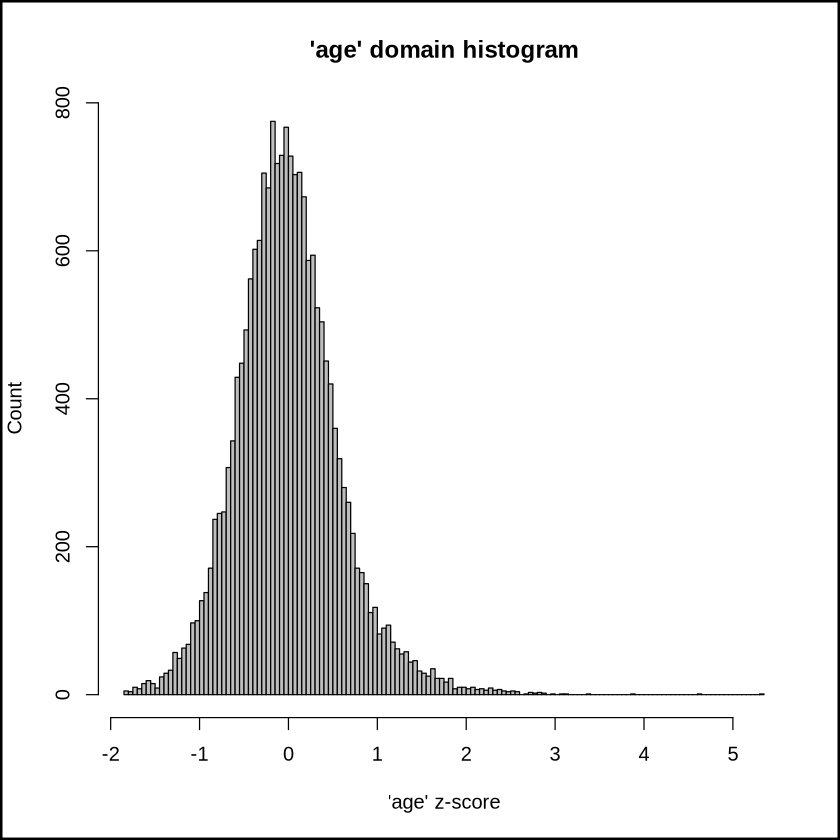

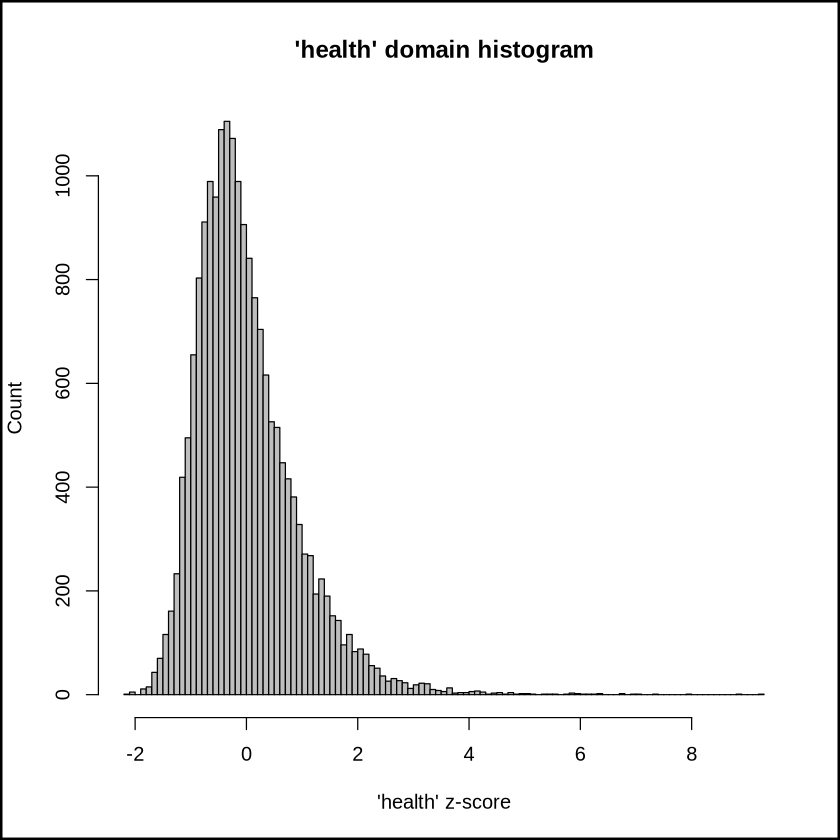

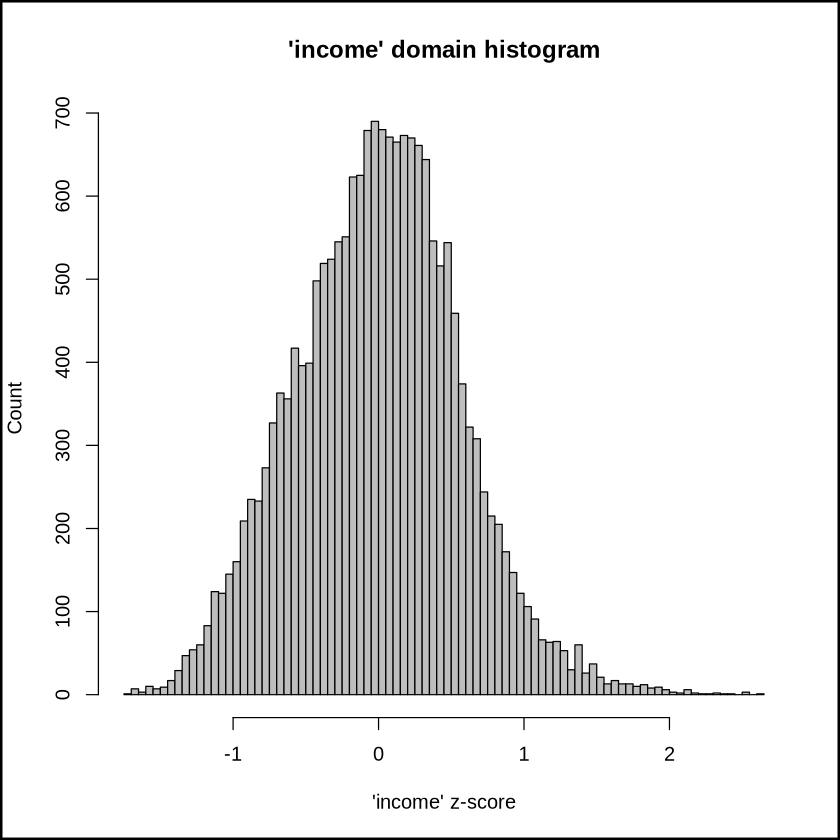

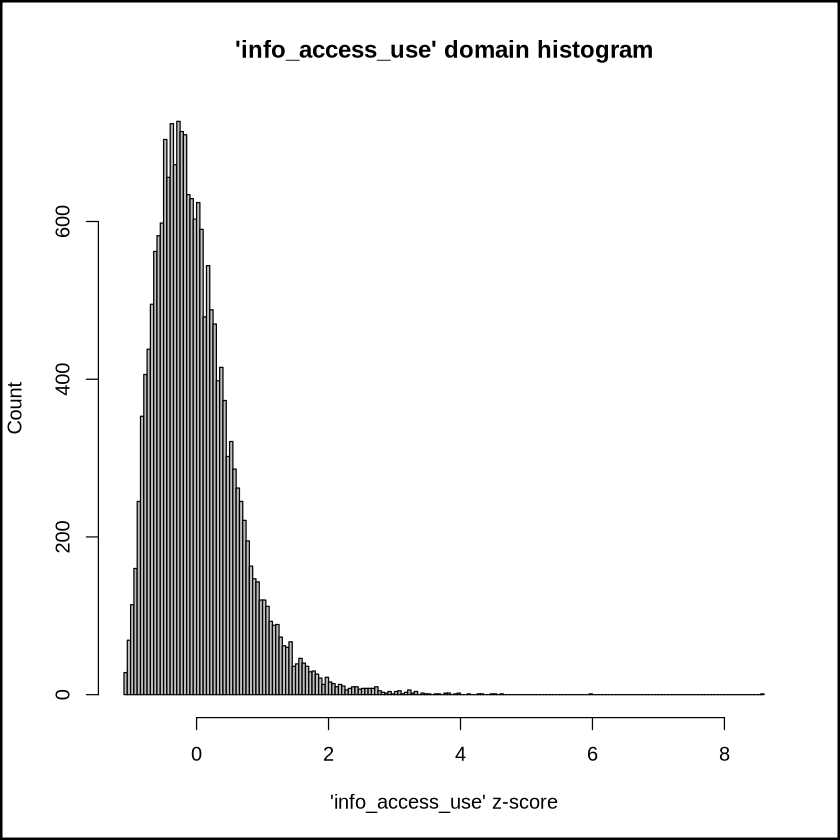

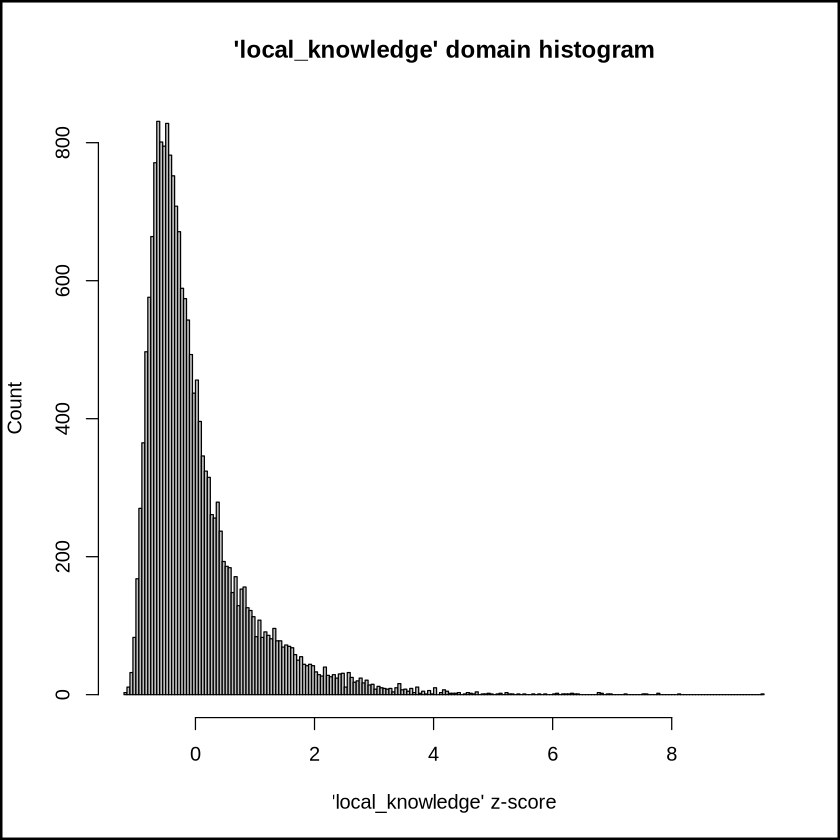

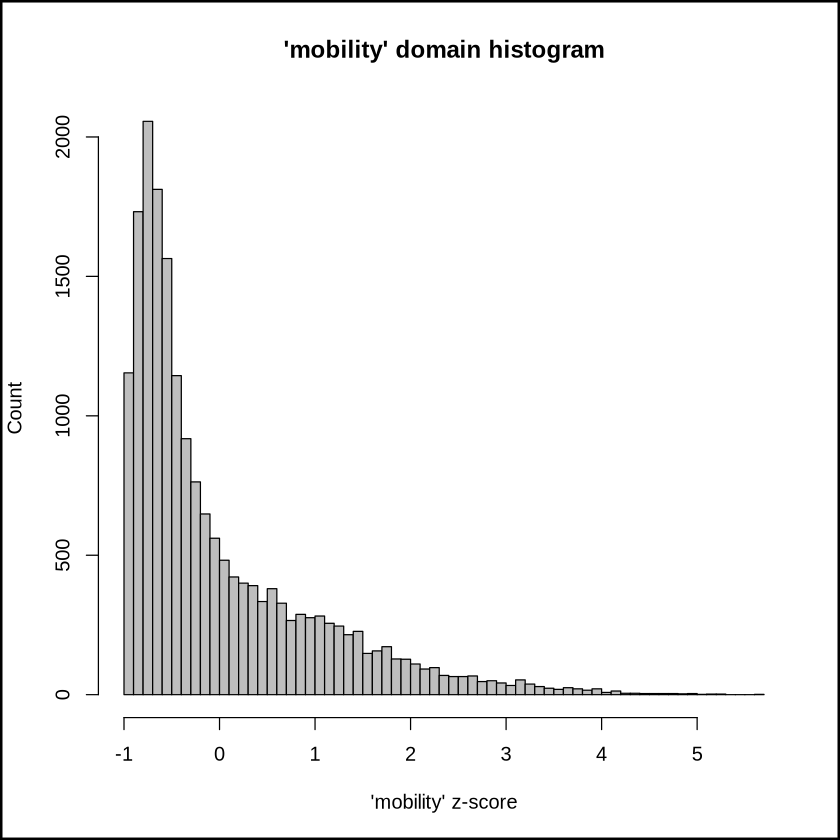

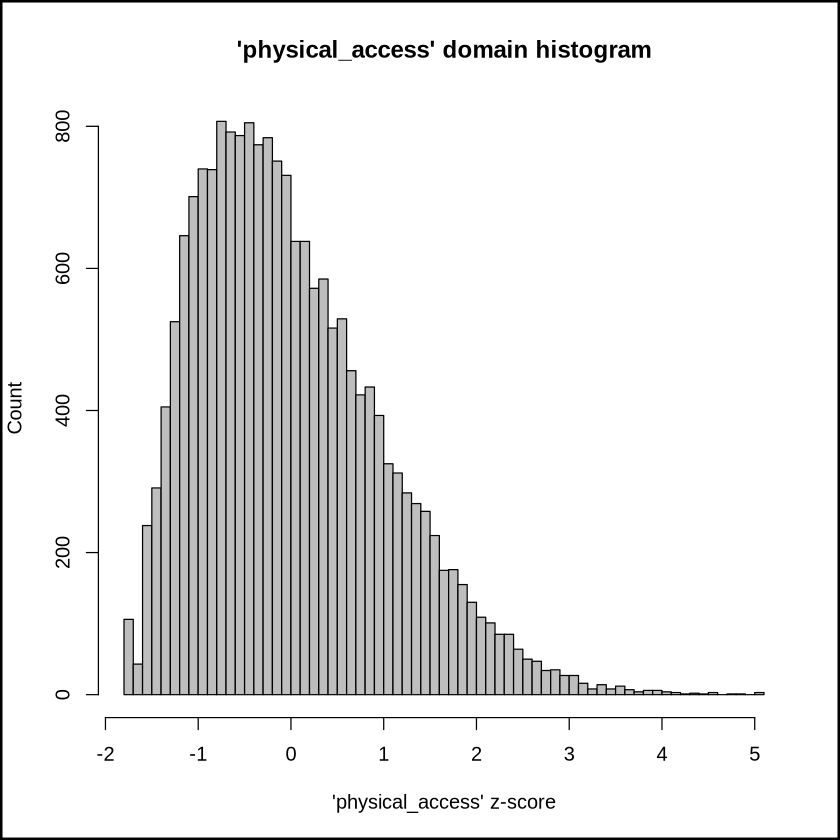

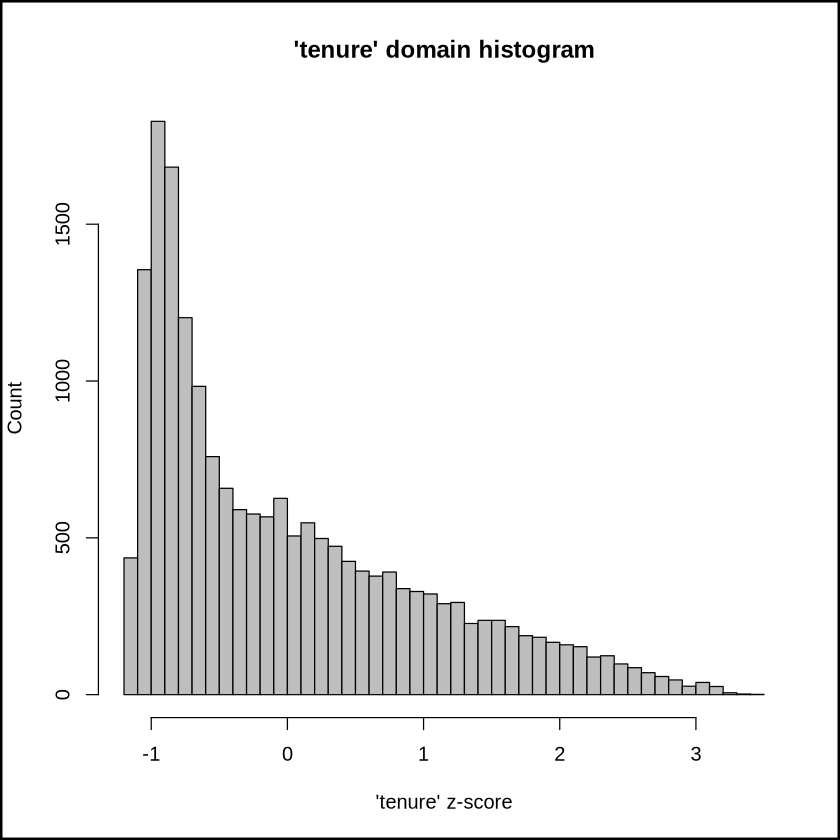

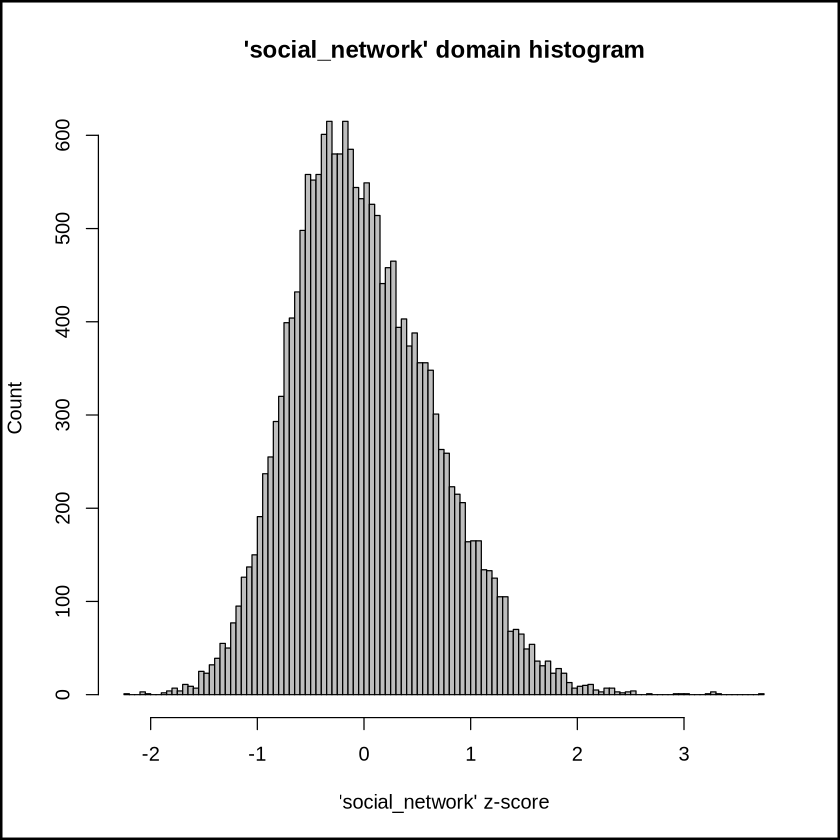

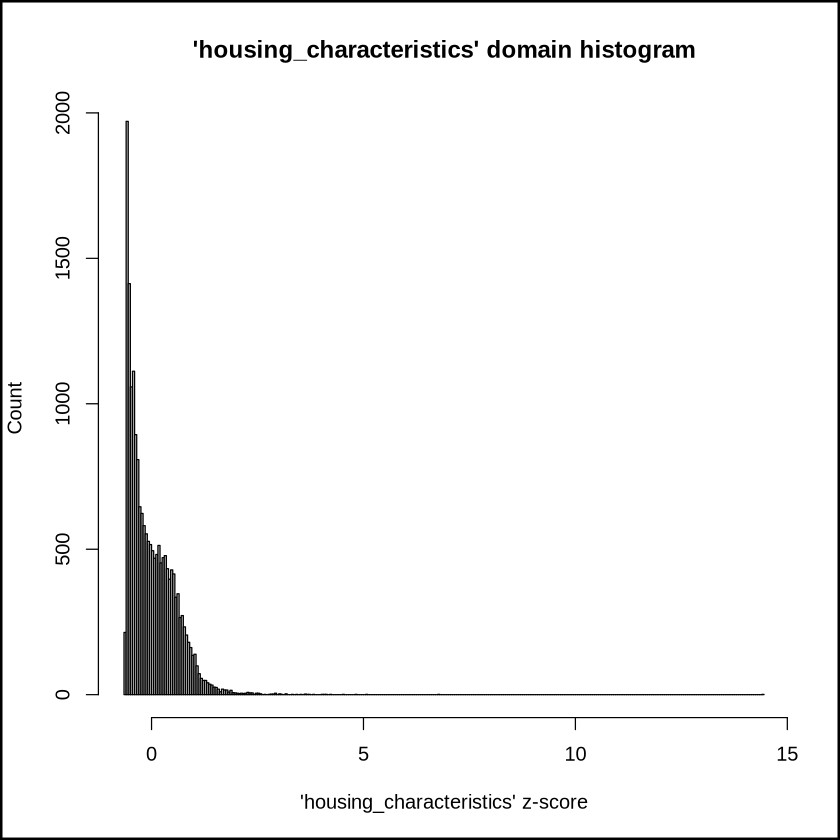

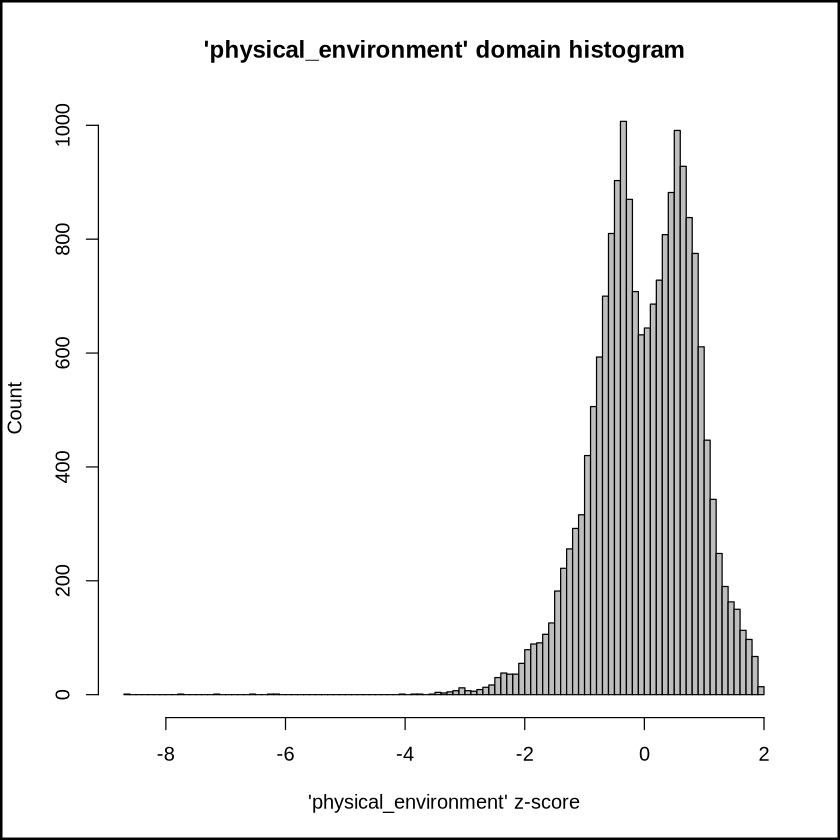

In [9]:
# Histogram visualisation of domain z-scores
for( current_domain in unique_domains ) {
    domain_scores_filtered <- domain_scores[,current_domain] 
    domain_scores_filtered[domain_scores_filtered == "NaN"] <- 0

    title <- paste("'", current_domain, "' domain histogram", sep = "")
    x_label <- paste("'", current_domain, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(domain_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

### Calculate dimension scores
Need to collate the domains into the dimensions

In [10]:
# Create a vector/array of the dimension names
dimensions <- c('sensitivity', 'prepare', 'respond', 'recover', 'adaptive_capacity', 'enhanced_exposure')

# Get the dimension and their associated indicator ID
dimension_indicators <- indicator_mapping %>% select(c('domain', all_of(dimensions)))
head(dimension_indicators)

# Initialise the dimensions score dataset with the GUID
dimension_scores <- indicator_data_weighted %>% select(all_of(GUID))

# loop through each of the dimensions and:
for (current_dimension in dimensions){
    # Identify which indicators are used within this dimension (current_dimension)
    # Then select the indicators marked with value 1, which means that the indicator is part of the dimension
    current_dimension_info <- dimension_indicators %>% select(c('domain', all_of(current_dimension)))
    current_dimension_info <- current_dimension_info %>% filter(dimension_indicators[, current_dimension] == 1)

    # Get a array/vector of the unique domains in this dimension
    current_dimension_domains <- unique(current_dimension_info$domain)

    # Count the number of domains in this dimension
    dimension_domain_count <- length(current_dimension_domains)

    # Filter the domain scores dataset to only use the domains in the dimension, and add the GUID column name
    current_dimension_data <- domain_scores %>% select(c(all_of(GUID), all_of(current_dimension_domains)))  

    # Sum each data row to get the total score for the dimension
    current_dimension_data[, current_dimension] <- rowSums(current_dimension_data[2:(dimension_domain_count+1)], na.rm = TRUE)

    # Add the current dimension score to the overall results
    dimension_indicator_score <- current_dimension_data %>% select(all_of(GUID), all_of(current_dimension))
    dimension_scores <- merge(dimension_scores, dimension_indicator_score, by=GUID)  
}

# generate z-scores with the scale function in order to standardise the dimension data
dimension_scores <- dimension_scores %>% mutate_if(is.numeric, scale)

# Print the first part of the dimension scores, which are now collated into one table
head(dimension_scores)

domain sensitivity prepare respond recover adaptive_capacity
1 age    1           0       0       0       0                
2 age    1           0       0       0       0                
3 health 1           0       0       0       0                
4 health 1           0       0       0       0                
5 income 0           1       1       1       1                
6 income 0           1       1       1       1                
  enhanced_exposure
1 0                
2 0                
3 0                
4 0                
5 0                
6 0

SA_GUID__1                           sensitivity prepare    respond   
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  0.38290372 -0.4856123 -0.3377139
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -0.20594059 -1.0185818 -0.9052009
3 002b83e4-5cce-414a-8570-871a50ae0964 -0.09575557  1.3659655  1.7874752
4 005eec3f-d746-480f-ae2c-bc6f1151548d  0.46969785  1.3940082  0.8307672
5 00b00ae4-229d-455d-84f1-d6face4876b1  0.06504954  1.1356657 -0.5626938
6 00df2b78-66c8-4009-89e0-0e14e15e4208 -0.61841747 -0.5434782  0.5417954
  recover    adaptive_capacity enhanced_exposure
1 -1.3729086 -0.61316276       -0.3497016       
2 -0.5397312 -1.02866162       -0.2313086       
3 -0.1097374  1.32022239       -0.1301417       
4 -0.3008060  0.88678611        0.3410119       
5 -0.3603958  0.06607222       -0.1208251       
6 -1.2756320  0.04443066       -0.3770668

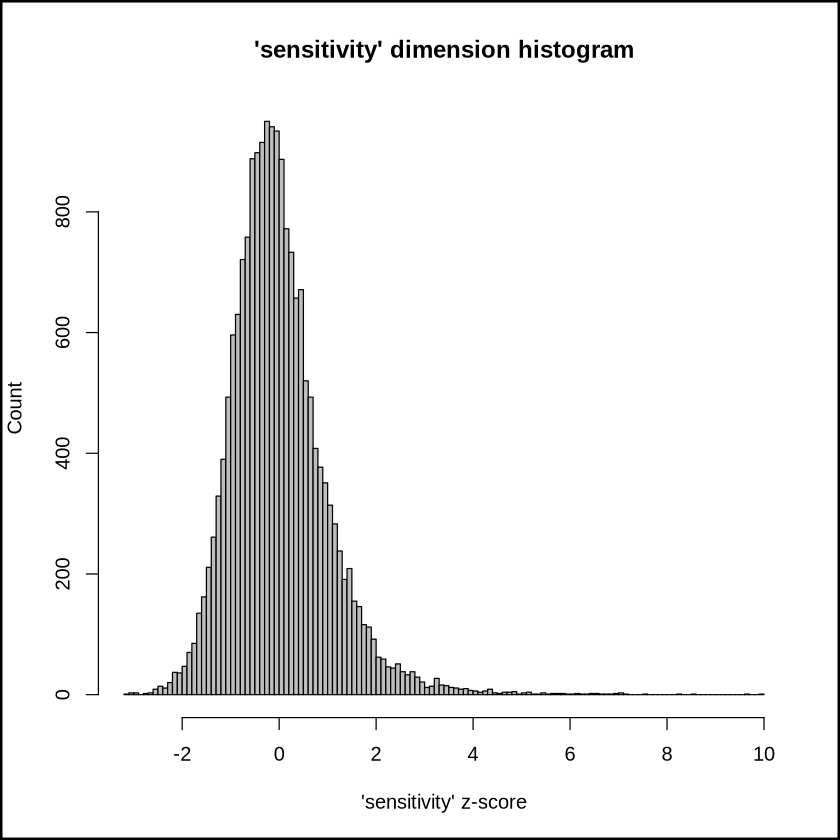

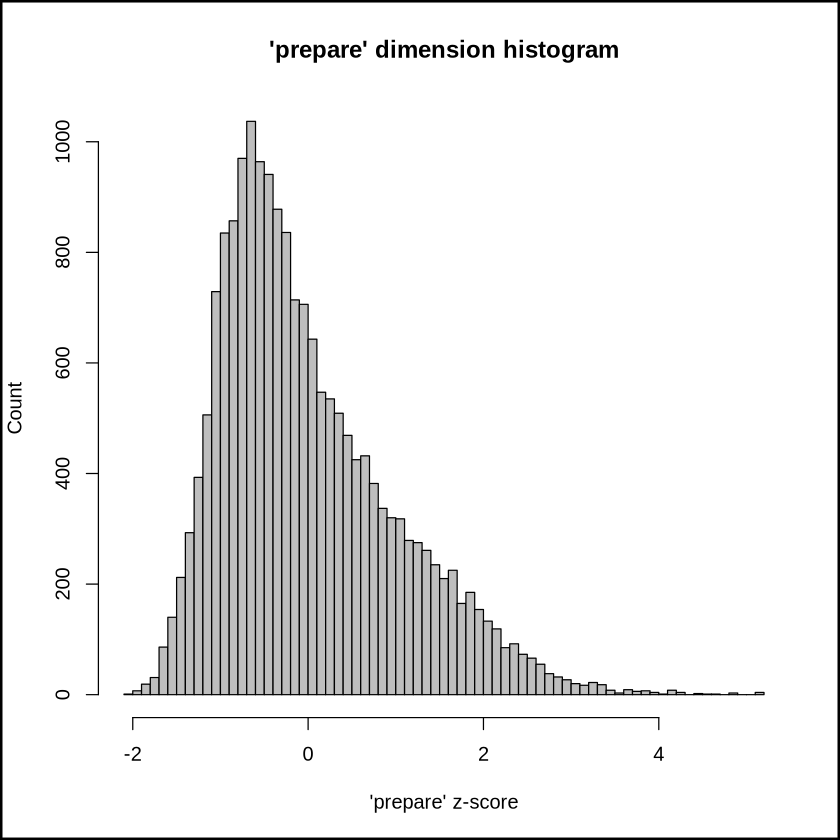

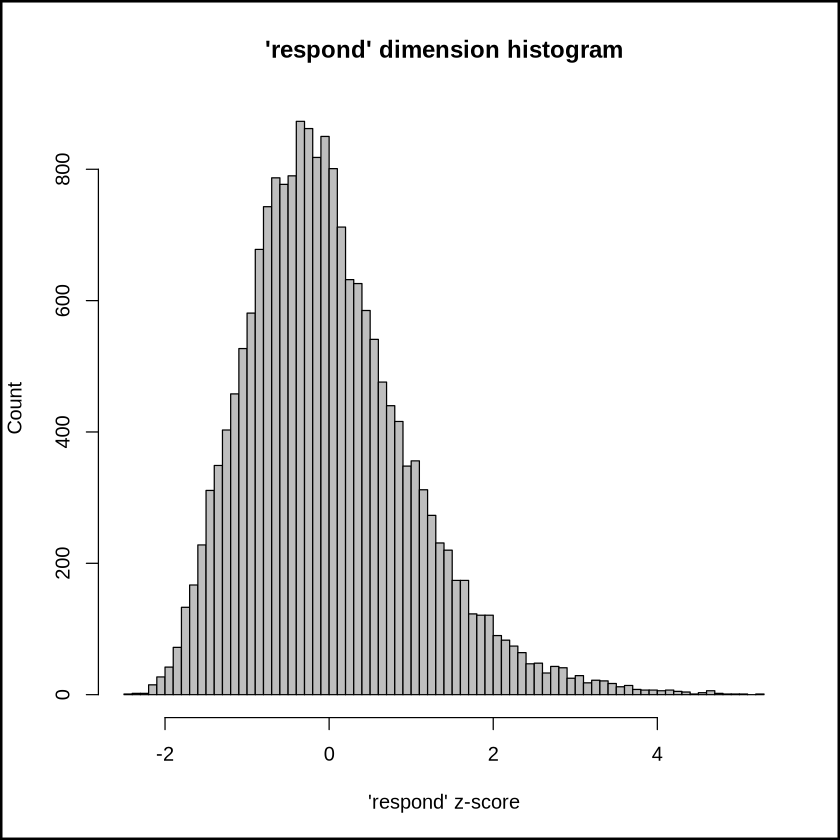

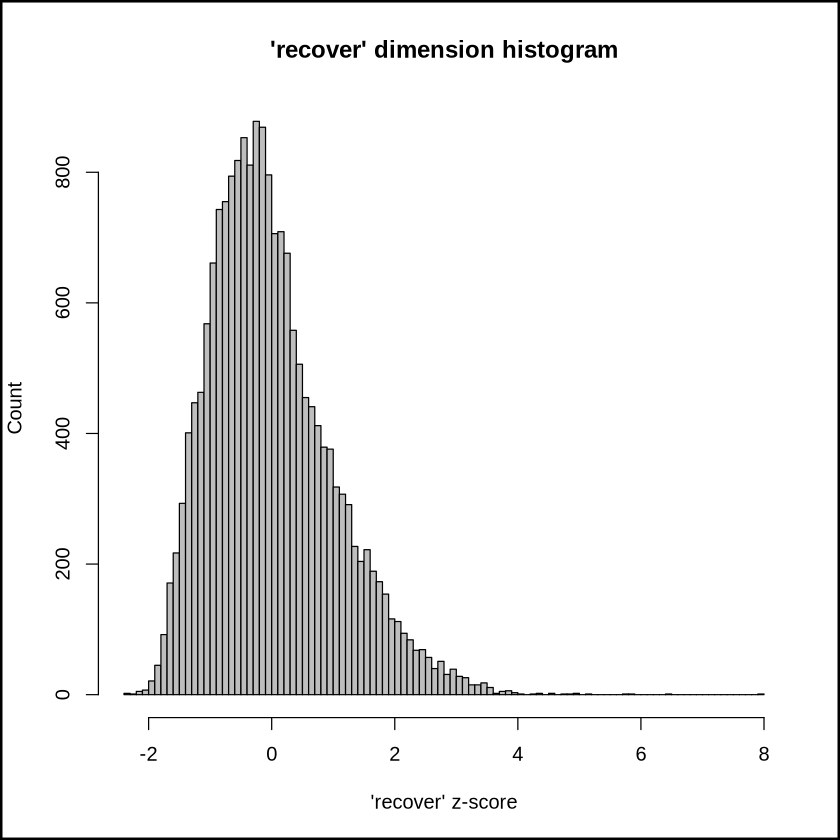

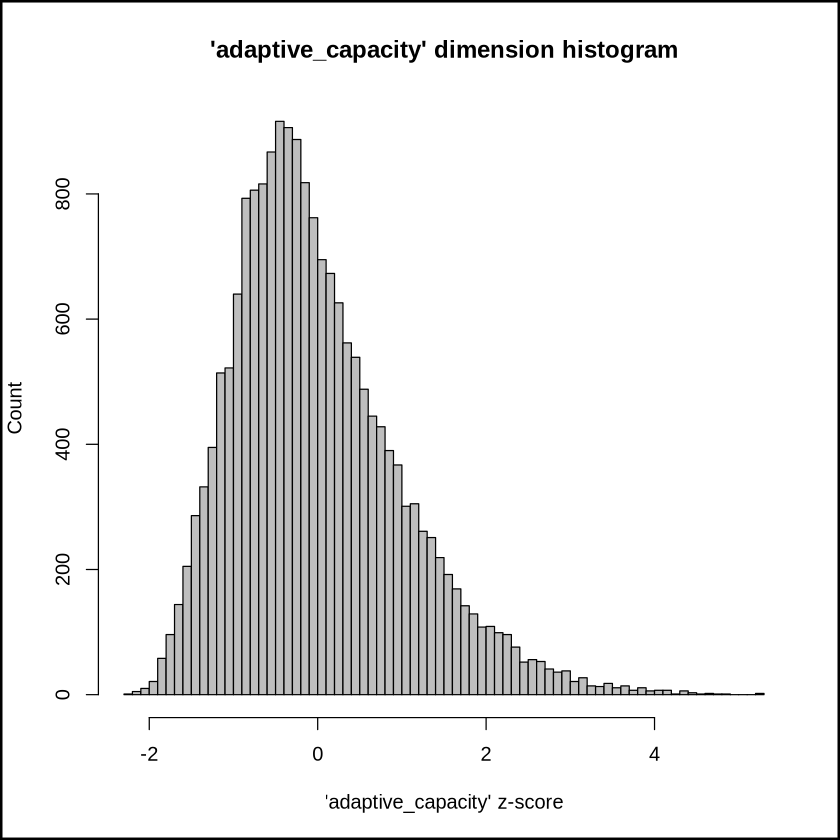

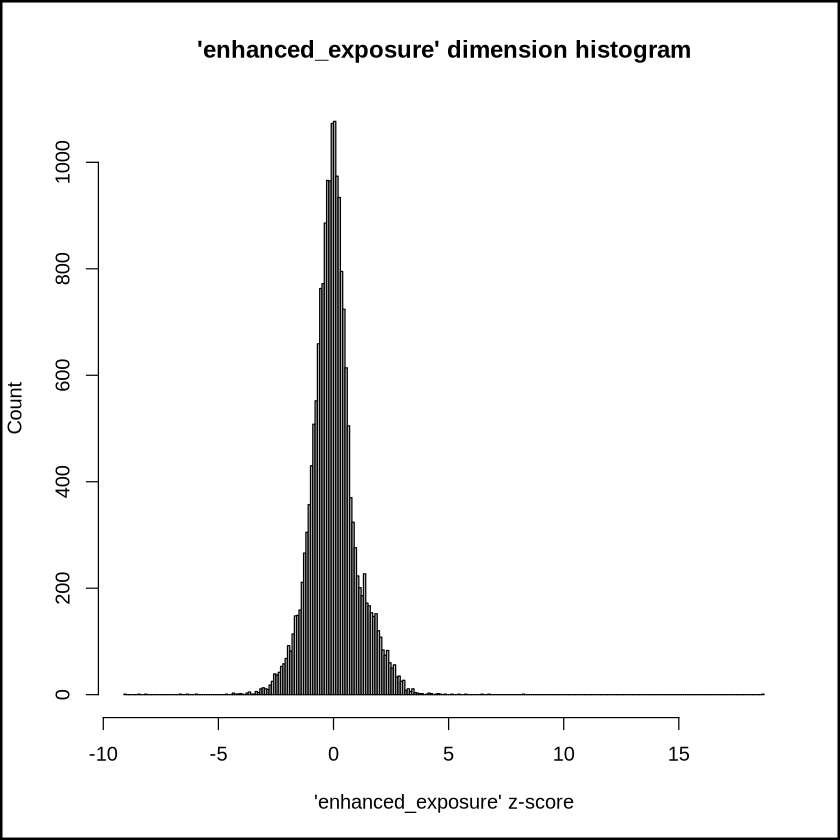

In [11]:
# Histogram visualisation of dimension z-scores
for( current_dimension in dimensions ){
    dimension_scores_filtered <- dimension_scores[,current_dimension] 
    dimension_scores_filtered[dimension_scores_filtered == "NaN"] <- 0
   
    title <- paste("'", current_dimension, "' dimension histogram", sep = "")
    x_label <- paste("'", current_dimension, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(dimension_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Calculate vulnerability score

In [12]:
# Initialise the vulnerability score dataset with the GUID
vulnerability_scores <- domain_scores %>% select(all_of(GUID))

#sum the domains to create a total overall score of vulnerability
vulnerability_scores$social_vulnerability <- rowSums(domain_scores[2:(ncol(domain_scores))], na.rm = TRUE)

# generate z-scores with the scale function in order to standardise the vulnerability data
vulnerability_scores <- vulnerability_scores %>% mutate_if(is.numeric, scale)

# Print the first part of the vulnerability scores, which are now collated into one table
head(vulnerability_scores)

SA_GUID__1                           social_vulnerability
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5 -0.33398100         
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -0.93275401         
3 002b83e4-5cce-414a-8570-871a50ae0964  1.13569837         
4 005eec3f-d746-480f-ae2c-bc6f1151548d  1.02930797         
5 00b00ae4-229d-455d-84f1-d6face4876b1  0.19607516         
6 00df2b78-66c8-4009-89e0-0e14e15e4208 -0.09735021

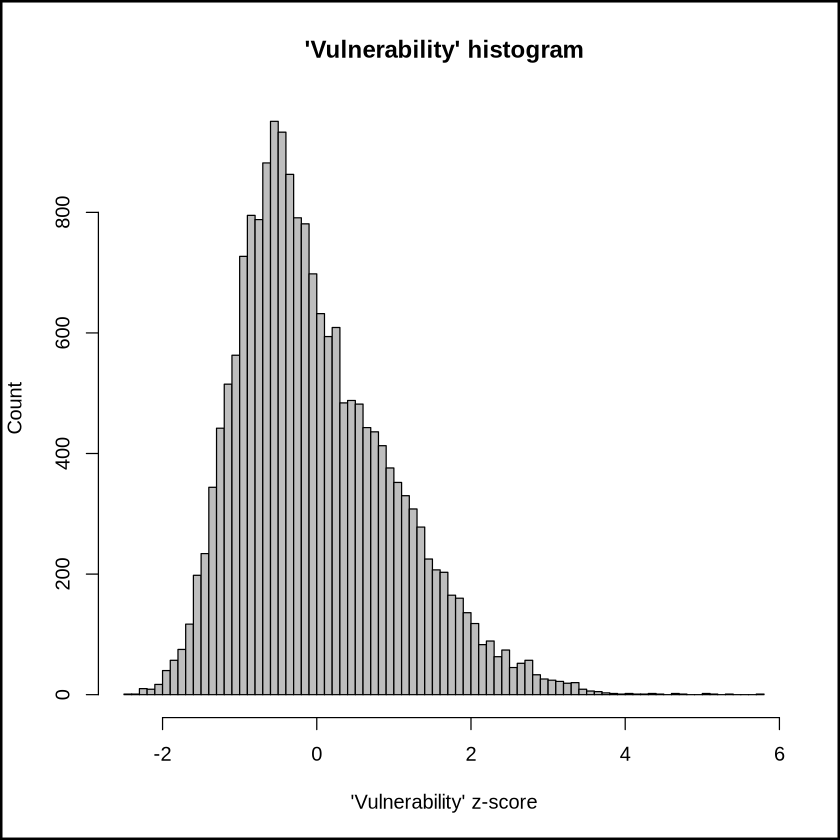

In [13]:
# Histogram visualisation of Vulnerability z-scores
title <- paste("'Vulnerability' histogram", sep = "")
x_label <- paste("'Vulnerability' z-score", sep = "")
y_label <- paste("Count", sep = "")
hist(vulnerability_scores$social_vulnerability, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
box("figure", lwd = 4)

In [14]:
# Merge all the indicators, domains, dimensions, and total vulnerability into one dataset
output_dataset <- merge(indicator_data_weighted, domain_scores, by=GUID)
output_dataset <- merge(output_dataset, dimension_scores, by=GUID)
output_dataset <- merge(output_dataset, vulnerability_scores, by=GUID)

head(output_dataset)

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  3.3880435      -0.8683184              
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -1.2041476       1.0830212              
3 002b83e4-5cce-414a-8570-871a50ae0964  0.2940109      -0.6563918              
4 005eec3f-d746-480f-ae2c-bc6f1151548d -1.3337162       1.4547264              
5 00b00ae4-229d-455d-84f1-d6face4876b1  1.7131001      -1.2060316              
6 00df2b78-66c8-4009-89e0-0e14e15e4208  1.5084163      -0.8589597              
  poor_health disability  one_parent_households
1 -0.72494112 -0.92235833 -0.9537932           
2  0.27801178 -0.62611003 -0.5813707           
3  0.07647292  0.06773408  0.3083236           
4  0.49313225  0.45603900 -1.0918818           
5 -0.32805634 -0.03080027  3.2416831           
6 -1.03118100 -1.02730679 -0.4959203           
  three_or_more_children_households low_skilled_employment farmers   
1 -0.28864382                       -0.3191812             -0.5775435
2  0.24855343                       -0.7175350              0.2814244
3 -0.06192013                       -0.7370951             -0.1126775
4 -1.18351563                       -1.9157382             -0.5775435
5  1.26642096                        1.5271694             -0.5775435
6 -0.57201990                        0.4816479             -0.4599295
  unemployment ⋯ social_network housing_characteristics physical_environment
1 -0.61650259  ⋯ -0.76239614    -0.51537733              0.2163239          
2 -0.23523246  ⋯ -0.08583099    -0.08272206             -0.1150856          
3  0.22240140  ⋯ -0.01340725    -0.43095487              0.3196619          
4 -0.07660151  ⋯  0.14327742    -0.34810226              0.6397246          
5  0.75768133  ⋯ -0.81129050    -0.57973227              0.4764065          
6 -0.97841257  ⋯ -0.53257202    -0.50830359              0.1858483          
  sensitivity prepare    respond    recover    adaptive_capacity
1  0.38290372 -0.4856123 -0.3377139 -1.3729086 -0.61316276      
2 -0.20594059 -1.0185818 -0.9052009 -0.5397312 -1.02866162      
3 -0.09575557  1.3659655  1.7874752 -0.1097374  1.32022239      
4  0.46969785  1.3940082  0.8307672 -0.3008060  0.88678611      
5  0.06504954  1.1356657 -0.5626938 -0.3603958  0.06607222      
6 -0.61841747 -0.5434782  0.5417954 -1.2756320  0.04443066      
  enhanced_exposure social_vulnerability
1 -0.3497016        -0.33398100         
2 -0.2313086        -0.93275401         
3 -0.1301417         1.13569837         
4  0.3410119         1.02930797         
5 -0.1208251         0.19607516         
6 -0.3770668        -0.09735021

## Correlations

In [15]:
# check the correlations
correlation <- cor(output_dataset %>% select(-c(all_of(GUID))), use="pairwise.complete.obs")
correlation

early_childhood age_middle_to_oldest_old
early_childhood                    1.000000000    -0.32493451             
age_middle_to_oldest_old          -0.324934515     1.00000000             
poor_health                       -0.196696114     0.30653419             
disability                        -0.348783559     0.52438012             
one_parent_households              0.098507657    -0.17156982             
three_or_more_children_households  0.253033549    -0.21339372             
low_skilled_employment             0.013435867    -0.01817412             
farmers                           -0.019786008     0.11130965             
unemployment                      -0.130046641     0.07775926             
no_higher_education               -0.137898158     0.19614505             
speak_english                      0.159789220    -0.25558916             
no_internet                       -0.171955862     0.34737657             
new_residents                     -0.051379223    -0.15971228             
foreign_nationals                  0.089204917    -0.34831679             
no_car                            -0.225941633    -0.01883762             
rented                             0.002567175    -0.32199244             
journey_time                       0.158255605    -0.21205543             
not_volunteers                     0.108404034    -0.21304424             
primary_school_age                -0.582863517     0.37135841             
one_person_households             -0.289474835     0.36267025             
no_central_heating                -0.142289862     0.03779754             
private_water_supply               0.001127354     0.05584319             
year_built                        -0.207242519     0.17554207             
mobile_home                       -0.002882623     0.01460049             
unoccupied_dwellings              -0.091314689     0.18455898             
tree_cover_density                 0.034488254    -0.07166947             
impervious                        -0.091034560    -0.14914081             
age                                0.580975682     0.58097568             
health                            -0.301636240     0.45947425             
income                             0.075916346    -0.07553580             
info_access_use                   -0.078409030     0.15044432             
local_knowledge                    0.021418562    -0.28766827             
mobility                          -0.225941633    -0.01883762             
physical_access                    0.158255605    -0.21205543             
tenure                             0.002567175    -0.32199244             
social_network                    -0.383661598     0.26164119             
housing_characteristics           -0.160256869     0.16957675             
physical_environment              -0.033728676    -0.13170866             
sensitivity                        0.056874631     0.66096776             
prepare                            0.007452990    -0.26899725             
respond                           -0.130501679    -0.10851529             
recover                           -0.264650656     0.13857486             
adaptive_capacity                 -0.124768352    -0.15313015             
enhanced_exposure                 -0.136565749    -0.01957992             
social_vulnerability              -0.092781282     0.04026736             
                                  poor_health disability  
early_childhood                   -0.19669611 -0.348783559
age_middle_to_oldest_old           0.30653419  0.524380117
poor_health                        1.00000000  0.635159460
disability                         0.63515946  1.000000000
one_parent_households              0.30466708  0.265786342
three_or_more_children_households -0.20580461 -0.266763657
low_skilled_employment             0.29169722  0.279103306
farmers                           -0.13013724 -0.121518259
unemployment                       0.57211583  0.5527

## Add geometry

In [16]:
# add st_drop_geometry
output_dataset_geom <- merge(output_dataset, oa, by.x=GUID, by.y=GUID, all.x = TRUE)
head(output_dataset_geom)

SA_GUID__1                           early_childhood age_middle_to_oldest_old
1 000581a3-4ebd-4a74-b5f8-0bd78cd7ede5  3.3880435      -0.8683184              
2 00275248-3d78-4fdb-8e5c-8ff1f76aebea -1.2041476       1.0830212              
3 002b83e4-5cce-414a-8570-871a50ae0964  0.2940109      -0.6563918              
4 005eec3f-d746-480f-ae2c-bc6f1151548d -1.3337162       1.4547264              
5 00b00ae4-229d-455d-84f1-d6face4876b1  1.7131001      -1.2060316              
6 00df2b78-66c8-4009-89e0-0e14e15e4208  1.5084163      -0.8589597              
  poor_health disability  one_parent_households
1 -0.72494112 -0.92235833 -0.9537932           
2  0.27801178 -0.62611003 -0.5813707           
3  0.07647292  0.06773408  0.3083236           
4  0.49313225  0.45603900 -1.0918818           
5 -0.32805634 -0.03080027  3.2416831           
6 -1.03118100 -1.02730679 -0.4959203           
  three_or_more_children_households low_skilled_employment farmers   
1 -0.28864382                       -0.3191812             -0.5775435
2  0.24855343                       -0.7175350              0.2814244
3 -0.06192013                       -0.7370951             -0.1126775
4 -1.18351563                       -1.9157382             -0.5775435
5  1.26642096                        1.5271694             -0.5775435
6 -0.57201990                        0.4816479             -0.4599295
  unemployment ⋯ housing_characteristics physical_environment sensitivity
1 -0.61650259  ⋯ -0.51537733              0.2163239            0.38290372
2 -0.23523246  ⋯ -0.08272206             -0.1150856           -0.20594059
3  0.22240140  ⋯ -0.43095487              0.3196619           -0.09575557
4 -0.07660151  ⋯ -0.34810226              0.6397246            0.46969785
5  0.75768133  ⋯ -0.57973227              0.4764065            0.06504954
6 -0.97841257  ⋯ -0.50830359              0.1858483           -0.61841747
  prepare    respond    recover    adaptive_capacity enhanced_exposure
1 -0.4856123 -0.3377139 -1.3729086 -0.61316276       -0.3497016       
2 -1.0185818 -0.9052009 -0.5397312 -1.02866162       -0.2313086       
3  1.3659655  1.7874752 -0.1097374  1.32022239       -0.1301417       
4  1.3940082  0.8307672 -0.3008060  0.88678611        0.3410119       
5  1.1356657 -0.5626938 -0.3603958  0.06607222       -0.1208251       
6 -0.5434782  0.5417954 -1.2756320  0.04443066       -0.3770668       
  social_vulnerability geometry                      
1 -0.33398100          MULTIPOLYGON (((676048.9 72...
2 -0.93275401          MULTIPOLYGON (((637187.3 72...
3  1.13569837          MULTIPOLYGON (((645674.5 69...
4  1.02930797          MULTIPOLYGON (((716705.1 72...
5  0.19607516          MULTIPOLYGON (((697195.3 79...
6 -0.09735021          MULTIPOLYGON (((662960.4 71...

# Export

In [17]:
# CSV
write.csv(output_dataset, file.path(output_dir, "social_vulnerability_index_ireland_2022.csv"), row.names = FALSE)

# GeoJSON
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_ireland_2022.geojson"), delete_dsn=TRUE)

# Shapefile
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_ireland_2022.shp"), append = FALSE)

Deleting source `../../3_outputs/Ireland/2022/social_vulnerability_index_ireland_2022.geojson' using driver `GeoJSON'
Writing layer `social_vulnerability_index_ireland_2022' to data source 
  `../../3_outputs/Ireland/2022/social_vulnerability_index_ireland_2022.geojson' using driver `GeoJSON'
Writing 18919 features with 46 fields and geometry type Multi Polygon.


Warning message in abbreviate_shapefile_names(obj):
“Field names abbreviated for ESRI Shapefile driver”


Deleting layer `social_vulnerability_index_ireland_2022' using driver `ESRI Shapefile'
Writing layer `social_vulnerability_index_ireland_2022' to data source 
  `../../3_outputs/Ireland/2022/social_vulnerability_index_ireland_2022.shp' using driver `ESRI Shapefile'
Writing 18919 features with 46 fields and geometry type Multi Polygon.


**END**